# Demonstrating the impact of imposing long-term priors

Just a simple and potentially (likely?) stupid approach to imposing long-term priors.

# Setup

## Imports

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import pandas as pd
import pydmd
from pydmd.bopdmd import BOPDMD
import colorednoise as cn

# OS interaction
import os
import sys

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import DateFormatter


The optDMD raises several warnings. They are disabled by the below lines to make the output of the examples cleaner, but there are several points that need to be cleaned up.

-> This may be no longer necessary due to using the pydmd classes

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from pyoptdmd import optimalDMD
from pyoptdmd import bop_dmd as kl_bopdmd

## Format plots

In [4]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
sns.set_context('paper')

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = [
    '#4477AA',
    '#CCBB44',
    '#EE6677',
    '#228833',
    '#66CCEE',
    '#AA3377',
    '#BBBBBB'
]
sns.set_palette(sns.color_palette(tol_bright_reorder))

# Helper functions

## xarray containers for ensemble results

This is not strictly necessary, but xarray is a nice data container that enables easier exploration of ensemble results.

In [5]:
def build_ensemble_xarray(data, ds_previous=None, num_eigenvalues=3,
                          column_name='ensemble member',
                          concat_dim='cycle', variable_name='eigenvalue'):
    """Convert fitted eigenvalues to an xarray Dataset.
    
    Dataset has coordinates of index (a melt of eigenvalue and ensemble member) 
    and cycle (number of ensembles created). The cycle dimension is the dimension
    along which ensembles are stacked in the concatenation.
    """
    
    # Build the eigenvalues dimension
    eigenvalues_coord = [str(k) for k in np.arange(1, num_eigenvalues + 1)]
    
    # Convert to a Pandas dataframe to use the melt function.
    # Build the real component
    df_real = pd.DataFrame(
        data=data.real,
    )

    df_real[variable_name] = eigenvalues_coord
    df_real.columns.names = [column_name]

    df_real = pd.melt(df_real, id_vars=variable_name, value_name='real')

    mi = pd.MultiIndex.from_frame(df_real[[column_name, variable_name]])
    df_real.index = mi
    df_real = df_real.drop([column_name, variable_name], axis=1)

    # Build the imaginary component.
    df_imag = pd.DataFrame(
        data=data.imag,
    )

    df_imag[variable_name] = eigenvalues_coord
    df_imag.columns.names = [column_name]

    df_imag = pd.melt(df_imag, id_vars=variable_name, value_name='imag')

    mi = pd.MultiIndex.from_frame(df_imag[[column_name, variable_name]])
    df_imag.index = mi
    df_imag = df_imag.drop([column_name, variable_name], axis=1)

    # Concatenate the real and imaginary components into a single Dataframe.
    df = pd.concat(
        [df_real, df_imag], axis=1
    )

    # Convert to xarray since this better handles the multidimensional data.
    ds = xr.Dataset.from_dataframe(df)
    if ds_previous is None:
        ds = ds
    else:
        ds = xr.concat([ds_previous, ds], dim=concat_dim)
    return ds

## Evaluation plots

A helper plotting function to simplify making the same plot for each test.

In [6]:
def eigenvalue_scatterplot(ds_plot, true_eigenvalues, lims=(-3, 3)):
    """Distribution of eigenvalues using a seaborn jointplot.
    
    """
    
    g = sns.scatterplot(
        data=ds_plot.to_dataframe(),
        x="real",
        y="imag",
        hue='eigenvalue',
        marker='D',
        legend=False,
    )

    for nk, k in enumerate(ds_plot.eigenvalue):
        ds = ds_plot.sel(eigenvalue=k)
        ds_mean = ds.mean(dim='noise realization')
        
        # Errorbars for each noise realization across the entire ensemble
        if 'real_std' in ds_plot.data_vars:
            g.errorbar(
                ds['real'],
                ds['imag'],
                xerr=ds['real_std'],
                yerr=ds['real_std'],
                fmt='none',
                color=tol_bright_reorder[nk],
                zorder=0,
                alpha=0.5,
            )
        
        # Mean across all realizations
        g.scatter(
            ds_mean['real'],
            ds_mean['imag'],
            50,
            color=tol_bright_reorder[nk],
            marker='s',
            edgecolor='k',
            linewidth=1,
        )

    for nte, te in enumerate(true_eigenvalues):
        g.scatter(
            np.real(te),
            np.imag(te),
            50,
            color=tol_bright_reorder[nte],
            marker='o',
            edgecolor='k',
            linewidth=1,
        )
    
    legend_elements = [
        Line2D(
            [0], [0], color='0.5', marker='D', ls='None',
            label='Individual Ensembles'),
        Line2D(
            [0], [0], color='0.5', marker='o', markeredgecolor='k',
            ls='None', label='True Eigenvalues'),
        Line2D(
            [0], [0], color='0.5', marker='s', markeredgecolor='k',
            ls='None', label='Mean of realizations'),
    ]
    g.legend(handles=legend_elements, loc='upper right')
    g.set_aspect('equal')
    g.set(xlim=lims, ylim=lims)
    
    return g

## Relative Error

In [7]:
def relative_error(xprime, x):
    return np.linalg.norm(xprime - x) / np.linalg.norm(x)

## Create toy data

In [8]:
def simple_example(spatial_modes, eigenvalue_array, ts, phase):
    x = np.zeros((spatial_modes[0].size, ts.size), np.complex128)
    for sp, e, c in zip(spatial_modes, eigenvalue_array, phase):
        x += sp.dot(np.exp(e * ts + c * 1j))
    return x

## Driver for Fitting Noisy Realizations

In [9]:
def run_noisy_realizations(
    data, ts, sigma_array, num_noise_cycles, num_ensembles,
    ensemble_size, true_eigs, seed=1, ts_longterm=None,
    data_longterm=None, verbose=False, red_noise=False, num_modes=3,
    ts_forecast=None, data_forecast=None): 

    # Set the random seed
    rng = np.random.default_rng(seed)
    
    num_sigmas = len(sigma_array)

    # Substantiate the dataset variables.
    ds_optdmd = None
    ds_entire_ensemble_bopdmd = None
    ds_std_bopdmd = None
    ds_mean_bopdmd = None

    optdmd_container = {}
    bopdmd_container = {}
    
    if ts_forecast is not None and data_forecast is not None:
        msg = 'Different number of time steps in forecast time series and data'
        assert(ts_forecast.size == data_forecast.shape[1], msg)
        forecast = True
    else:
        forecast = False

    # Create containers for error statistics
    error_reconstruct = np.zeros((num_sigmas, num_noise_cycles, num_ensembles))
    error_eigs = np.zeros((num_sigmas, num_modes, num_noise_cycles))

    error_reconstruct_opt = np.zeros((num_sigmas, num_noise_cycles))
    error_eigs_opt = np.zeros((num_sigmas, num_modes, num_noise_cycles))

    # Additionally create a container for the forecast error
    if forecast:
        error_forecast = np.zeros((num_sigmas, num_noise_cycles, num_ensembles))
        error_forecast_opt = np.zeros((num_sigmas, num_noise_cycles))
        
    for nsigma, sigma in enumerate(sigma_array):
        if verbose:
            print('')
            print('======================')
            print('sigma={}\n'.format(sigma))

        # Create containers for the eigenvalues
        e_optDMD = np.zeros((num_modes, num_noise_cycles)).astype(complex)
        e_mean_BOPDMD = np.zeros((num_modes, num_noise_cycles)).astype(complex)
        e_std_BOPDMD = np.zeros((num_modes, num_noise_cycles))
        
        optdmd_container[sigma] = []
        bopdmd_container[sigma] = []

        for k in range(num_noise_cycles):
            if verbose:
                print(
                    'Working on realization {} out of {} total noisy realizations.'.format(
                        k + 1,
                        num_noise_cycles
                    ),
                )

            # Create data for noise cycle by adding random noise to both the imaginary
            # and real components of the input data.

            # The number of samples to generate (aka the length of the time dimension)
            if forecast:
                forecast_length = data_forecast.shape[1]
                samples = data.shape[1] + forecast_length
            else:
                samples = data.shape[1]
            
             # Add red noise to the input data.
            if red_noise:
                # The exponent for red noise  spectra (given to colorednoise library)
                beta = 2
                
                if np.iscomplex(data).any():
                    # Noise is generated for each spatial point in time.
                    rn_r = np.array(
                        [
                            cn.powerlaw_psd_gaussian(beta, samples, random_state=rng)
                            for _, _ in enumerate(range(data.shape[0]))
                        ]
                    )
                    rn_i = np.array(
                        [
                            cn.powerlaw_psd_gaussian(beta, samples, random_state=rng)
                            for _, _ in enumerate(range(data.shape[0]))
                        ]
                    )

                    # Scale the red noise to have the same scaling as white noise
                    rn_sigma_scaling = np.mean([sigma / rn_r.std(), sigma / rn_i.std()])
                    
                    if forecast:
                        xdata = (
                            data
                            + rn_sigma_scaling * rn_r[:, :-forecast_length]
                            + 1j * rn_sigma_scaling * rn_i[:, :-forecast_length]
                        )
                        xdata_forecast = (
                            data_forecast
                            + rn_sigma_scaling * rn_r[:, -forecast_length:]
                            + 1j * rn_sigma_scaling * rn_i[:, -forecast_length:]
                        )
                    else:
                        xdata = (
                            data
                            + rn_sigma_scaling * rn_r
                            + 1j * rn_sigma_scaling * rn_i
                        )
                else:
                    rn_r = np.array([cn.powerlaw_psd_gaussian(beta, samples, random_state=rng) for _, _ in enumerate(data.shape(0))])

                    # Scale the red noise to have the same scaling as white noise
                    rn_sigma_scaling = sigma / rn_r.std()
                    
                    if forecast:
                        xdata = data + rn_sigma_scaling * rn_r[:, :-forecast_length]
                        xdata_forecast = data_forecast + rn_sigma_scaling * rn_r[:, -forecast_length:]
                    else:
                        xdata = data + rn_sigma_scaling * rn_r

            # Add white noise to the input data
            else:
                if np.iscomplex(data).any():
                    wn_r = rng.standard_normal((data.shape[0], samples))
                    wn_i = rng.standard_normal((data.shape[0], samples))

                    if forecast:
                        xdata = (
                            data
                            + sigma * wn_r[:, :-forecast_length]
                            + 1j * sigma * wn_i[:, :-forecast_length]
                        )
                        xdata_forecast = (
                            data_forecast
                            + sigma * wn_r[:, -forecast_length:]
                            + 1j * sigma * wn_i[:, -forecast_length:]
                        )
                    else:
                        xdata = (
                            data
                            + sigma * wn_r
                            + 1j * sigma * wn_i
                        )
                    
                else:
                    wn_r = rng.standard_normal(samples)
                    if forecast:
                        xdata = data + sigma * wn_r[:, :-forecast_length]
                        xdata_forecast = data_forecast + sigma * wn_r[:, -forecast_length:]
                    else:
                        xdata = data + sigma * wn_r

            # Fit the optDMD and BOP-DMD
            e_ensembleDMD, bopdmd_ensemble, e_opt, optdmd = kl_bopdmd.fit(
                xdata, ts, num_modes, num_ensembles=num_ensembles,
                ensemble_size=ensemble_size, seed=seed,
                long_term_mean=data_longterm, long_term_ts=ts_longterm,

            )

            optdmd_container[sigma].append(optdmd)
            bopdmd_container[sigma].append(bopdmd_ensemble)

            # Match the eigenvalues to the true ones using the Munkres algorithm.
            _, indices = kl_bopdmd.match_vectors(e_opt, true_eigs)
            e_optDMD[:, k] = e_opt[indices]

            # The eigenvalues are matched to the optDMD eigenvalues, but these orders
            # may differ between realizations depending on the optDMD solution. Re-sort
            # the eigenvalues here relative to the true eigenvalues for the sake of comparison.
            for n in range(e_ensembleDMD.shape[1]):
                e = e_ensembleDMD[:, n]
                if np.isnan(e).any():
                    continue
                else:
                    _, indices = kl_bopdmd.match_vectors(e_ensembleDMD[:, n], true_eigs)
                    e_ensembleDMD[:, n] = e_ensembleDMD[indices, n]

                    
            # Store the mean, standard deviation, and error of the eigenvalues.
            # Note: this step assumes a fixed and known number of modes.
            e_mean_BOPDMD[:, k] = np.nanmean(e_ensembleDMD, 1)
            e_std_BOPDMD[:, k] = np.nanstd(e_ensembleDMD, 1)
            
            # Changed this to be absolute error and not relative.
            for nmode in range(num_modes):
                # error_eigs[nsigma, nmode, k] = (
                #     np.abs(e_mean_BOPDMD[nmode, k] - true_eigs[nmode])
                #     / np.abs(true_eigs[nmode])
                # )
                # error_eigs_opt[nsigma, nmode, k] = (
                #     np.abs(e_optDMD[nmode, k] - true_eigs[nmode])
                #     / np.abs(true_eigs[nmode])
                # )
                error_eigs[nsigma, nmode, k] = np.abs(e_mean_BOPDMD[nmode, k] - true_eigs[nmode])
                error_eigs_opt[nsigma, nmode, k] = np.abs(e_optDMD[nmode, k] - true_eigs[nmode])

            # Get the errors for the reconstruction and forecast.
            error_reconstruct_opt[nsigma, k] = relative_error(
                xdata,
                optdmd.forecast(ts)
            )
            if forecast:
                error_forecast_opt[nsigma, k] = relative_error(
                    xdata_forecast,
                    optdmd.forecast(ts_forecast)
                )

            for n in range(num_ensembles):
                error_reconstruct[nsigma, k, n] = relative_error(
                    xdata,
                    bopdmd_ensemble[n].forecast(ts)
                )

                if forecast:
                    error_forecast[nsigma, k, n] = relative_error(
                        xdata_forecast,
                        bopdmd_ensemble[n].forecast(ts_forecast)
                    )
            
            if verbose:
                print('------------------------------')
                print('Mean Eigenvalues Error {:.4f}'.format(error_eigs[:, k]))
                print('std Eigenvalues:'.format())
                print(e_std_BOPDMD[:, k])
                print('------------------------------')
                print()

        # Build the xarray containers for the results of each noise realization.

        # First, build the optdmd results container.
        ds_optdmd = build_ensemble_xarray(
            e_optDMD,
            ds_previous=ds_optdmd,
            column_name='noise realization',
            concat_dim='sigma',
            num_eigenvalues=num_modes,
        )

        # Second, build the containers for the mean and standard deviation of the BOP-DMD. 
        ds_mean_bopdmd = build_ensemble_xarray(
            e_mean_BOPDMD,
            ds_previous=ds_mean_bopdmd,
            variable_name='eigenvalue',
            column_name='noise realization',
            concat_dim='sigma',
            num_eigenvalues=num_modes,
        )

        ds_std_bopdmd = build_ensemble_xarray(
            e_std_BOPDMD,
            ds_previous=ds_std_bopdmd,
            variable_name='eigenvalue',
            column_name='noise realization',
            concat_dim='sigma',
            num_eigenvalues=num_modes,
        )

    # Clean up variables and labels.
    new_names = {dv: dv + '_std' for dv in ds_std_bopdmd.data_vars}
    ds_std_bopdmd = ds_std_bopdmd.rename_vars(new_names)
    ds_mean_bopdmd.coords['sigma'] = sigma_array
    ds_std_bopdmd.coords['sigma'] = sigma_array
    ds_bopdmd = xr.merge([ds_mean_bopdmd, ds_std_bopdmd])
    ds_optdmd.coords['sigma'] = sigma_array
   
    ds_bopdmd.coords['_member'] = (np.arange(0, num_ensembles))
    ds_bopdmd['error_reconstruction'] = (('sigma', 'noise realization', '_member'), error_reconstruct)
    ds_bopdmd['error_eigs'] = (('sigma', 'eigenvalue', 'noise realization'), error_eigs)

    ds_optdmd.coords['_member'] = (np.arange(0, num_ensembles))
    ds_optdmd['error_reconstruction'] = (('sigma', 'noise realization'), error_reconstruct_opt)
    ds_optdmd['error_eigs'] = (('sigma', 'eigenvalue', 'noise realization'), error_eigs_opt)
    
    if forecast:
        ds_bopdmd['error_forecast'] = (('sigma', 'noise realization', '_member'), error_forecast)
        ds_optdmd['error_forecast'] = (('sigma', 'noise realization'), error_forecast_opt)

    return ds_optdmd, ds_bopdmd, optdmd_container, bopdmd_container


In [10]:
def calculate_error():
    reconstructed_error = np.zeros((num_ensembles))
    forecast_error = np.zeros((num_ensembles))

    r = 0
    s = 0.5
    for n in range(num_ensembles):
        reconstructed_error[n] = relative_error(
            xclean,
            bopdmd_container_climatology[s][r][n].forecast(ts)
        )
        forecast_error[n] = relative_error(
            xclean_forecast,
            bopdmd_container_climatology[s][r][n].forecast(ts_forecast)
        )

## Certainty Donut

In [11]:
def certainty_donut(radii):
    """Generates x and y coords for the certainty donut.
    
    https://stackoverflow.com/questions/22789356/plot-a-donut-with-fill-or-fill-between-use-pyplot-in-matplotlib
    
    """
    
    n = 50
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))

    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    xs = np.ravel(xs)
    ys = np.ravel(ys)
    
    return xs, ys

# Example Data

## Modified example with oscillating modes

+ 2 oscillating modes with no decay/growth
+ 1 slowly decaying, oscillating mode that is not fully resolved

In [12]:
# Generate the synthetic data.

# Set up modes in space.
x0 = 0
x1 = np.pi
nx = 200

# Space component is evenly spaced.
xspace = np.linspace(x0,x1,nx)

# Set up the spatial modes
f1 = np.sin(xspace)[:, np.newaxis]
f2 = np.cos(xspace)[:, np.newaxis]
f3 = np.tanh(xspace)[:, np.newaxis]

# Set up the time dimension.
t0 = 0
t1 = 0.25
t2 = t1 + t1 * 0.1
t_extended = int(t1 * 10)
num_timesteps_per_1s = 500
nt = int(num_timesteps_per_1s * t1)

ts = np.linspace(t0, t1, nt, endpoint=False)[np.newaxis, :]
ts_forecast = np.linspace(t1, t2, nt // 10, endpoint=False)[np.newaxis, :]
ts_extended = np.linspace(t0, t_extended, t_extended * num_timesteps_per_1s, endpoint=False)[np.newaxis, :]

# Temporal eigenvalues for each mode
e1 = -2.5 + 10j
e2 = 0 + 23j
e3 = 0 - 17j
true_eigenvalues = np.array([e1, e2, e3])
# Phase offset of the temporal modes
phase = [0, 0, -np.pi]

# Generate the clean, noiseless dynamics.
xclean = simple_example([f1, f2, f3], true_eigenvalues, ts, phase)
xclean_extended = simple_example([f1, f2, f3], true_eigenvalues, ts_extended, phase)
xclean_forecast = simple_example([f1, f2, f3], true_eigenvalues, ts_forecast, phase)

## Visualize

Text(0.5, 0, 'Time Dimension')

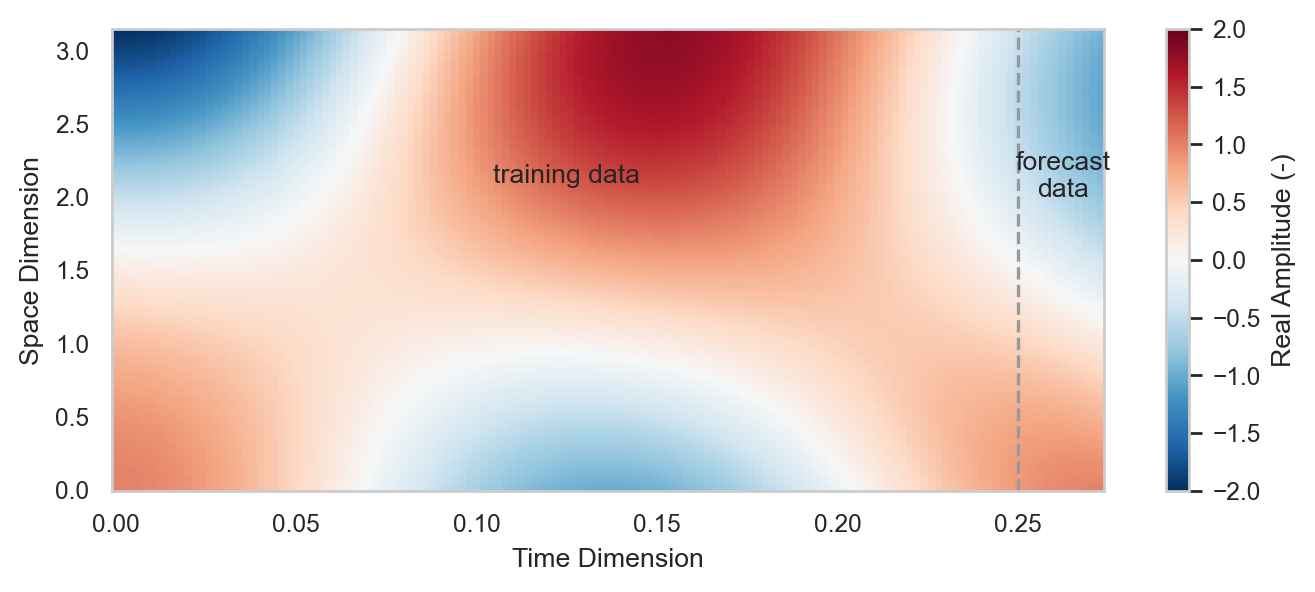

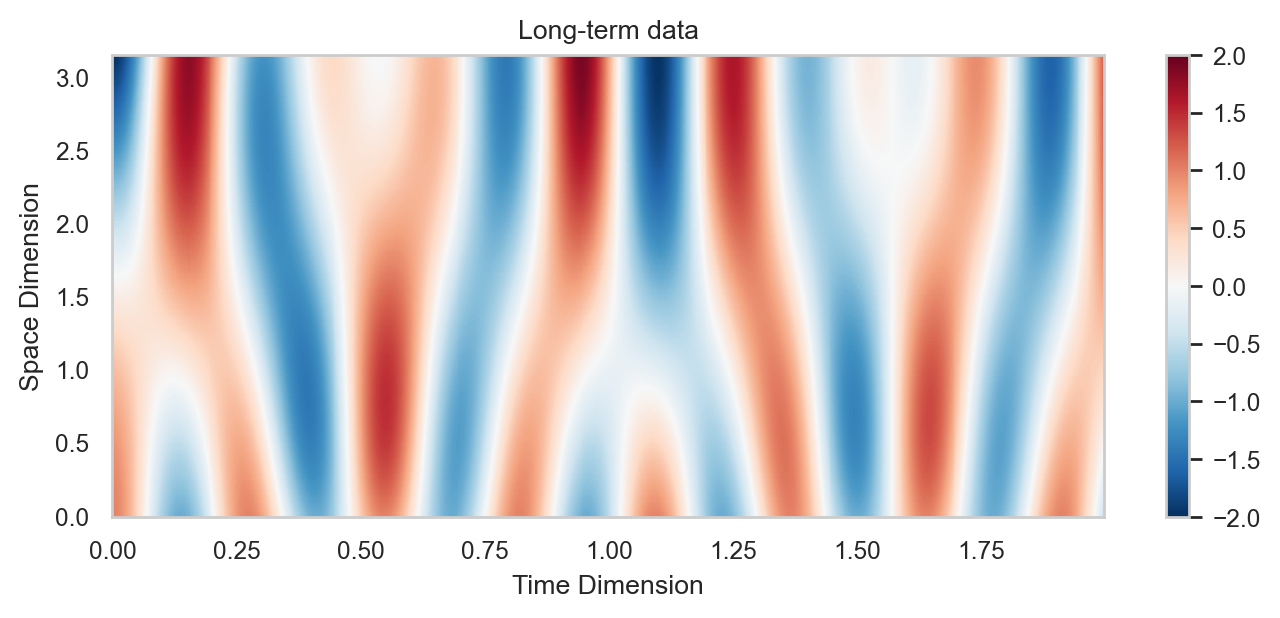

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
c = ax.pcolormesh(ts, xspace, np.real(xclean), vmin=-2, vmax=2, cmap='RdBu_r')
ax.pcolormesh(ts_forecast, xspace, np.real(xclean_forecast), vmin=-2, vmax=2, cmap='RdBu_r')
ax.text(t0 + (t1 - t0) / 2, x1 - x1 // 3, 'training data',
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transData)
ax.axvline(t1, color='0.6', ls='--')
ax.text(t1 + (t2 - t1) / 2, x1 - x1 // 3, 'forecast\ndata',
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transData)
cbar = fig.colorbar(c)
cbar.set_label('Real Amplitude (-)')
# ax.set_title('Simple Example')
ax.set_ylabel('Space Dimension')
ax.set_xlabel('Time Dimension')

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
c = ax.pcolormesh(ts_extended, xspace, np.real(xclean_extended), vmin=-2, vmax=2, cmap='RdBu_r')
fig.colorbar(c)
ax.set_title('Long-term data')
ax.set_ylabel('Space Dimension')
ax.set_xlabel('Time Dimension')


Text(0.5, 1.0, 'Spatial Modes of the Toy Data')

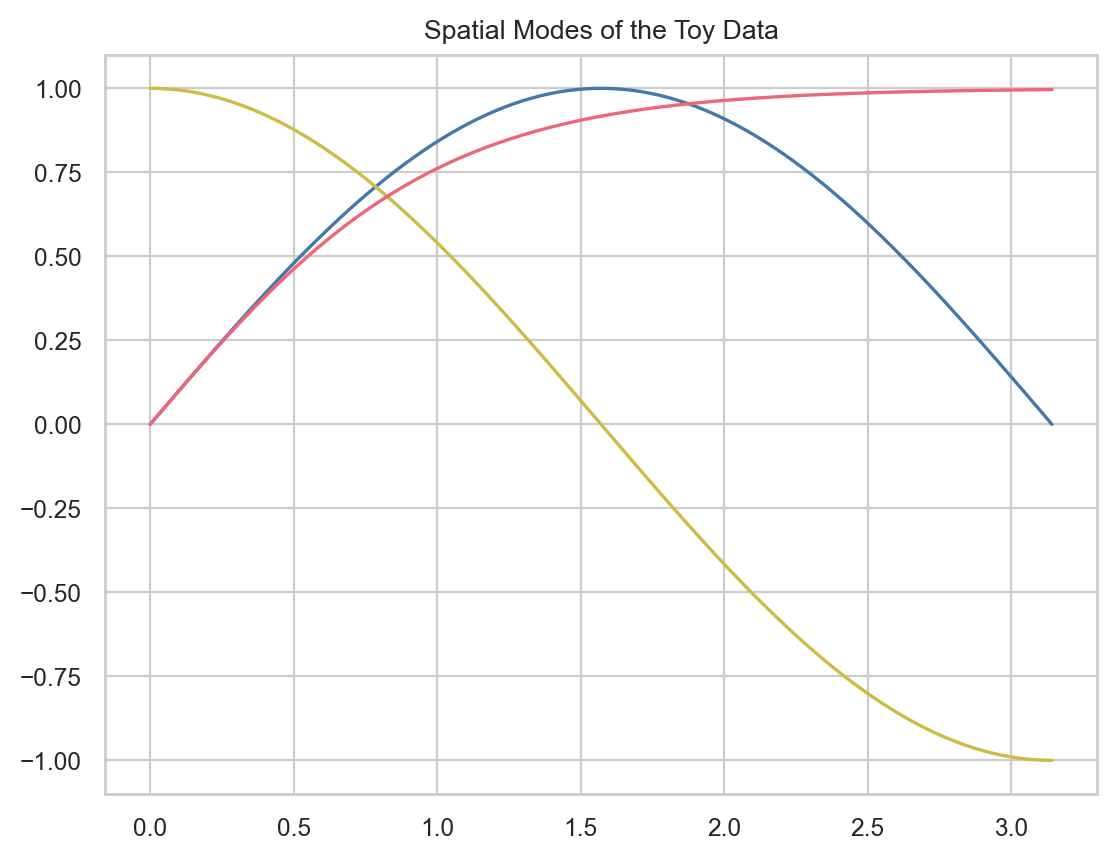

In [14]:
fig, ax = plt.subplots(1, 1)
ax.plot(xspace, f1)
ax.plot(xspace, f2)
ax.plot(xspace, f3)
ax.set_title('Spatial Modes of the Toy Data')

Text(0.5, 1.0, 'Temporal Modes of the Toy Data')

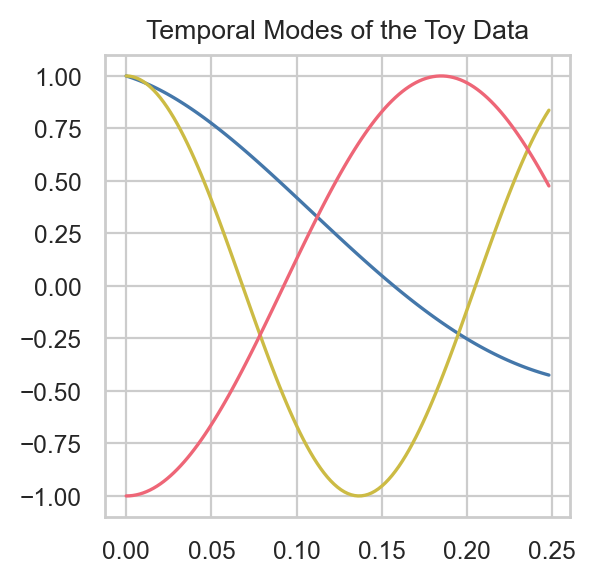

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ts_plot = np.linspace(t0, 2, nt)[np.newaxis, :]
ax.plot(ts.T, np.real(np.exp(e1 * ts)).T)
ax.plot(ts.T, np.real(np.exp(e2 * ts)).T)
ax.plot(ts.T, np.real(np.exp(e3 * ts - np.pi * 1j)).T)
ax.set_title('Temporal Modes of the Toy Data')

Text(0.5, 1.0, 'Temporal Modes of the Toy Data')

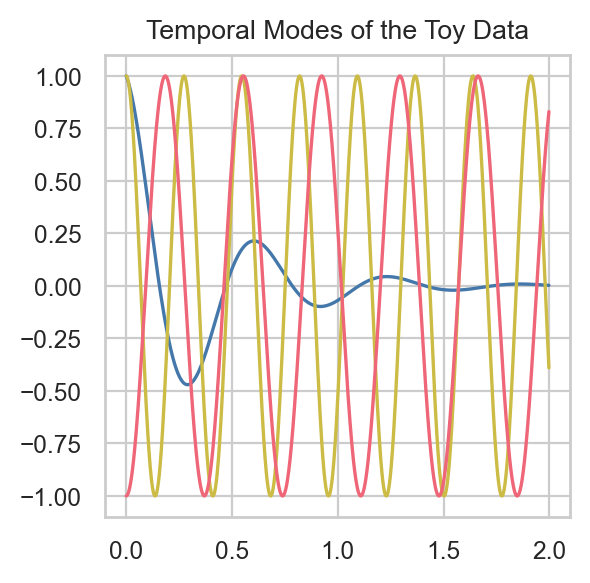

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ts_plot = ts_extended
ax.plot(ts_plot.T, np.real(np.exp(e1 * ts_plot)).T)
ax.plot(ts_plot.T, np.real(np.exp(e2 * ts_plot)).T)
ax.plot(ts_plot.T, np.real(np.exp(e3 * ts_plot - np.pi * 1j)).T)
ax.set_title('Temporal Modes of the Toy Data')

## Understand the red noise corruption of the toy data

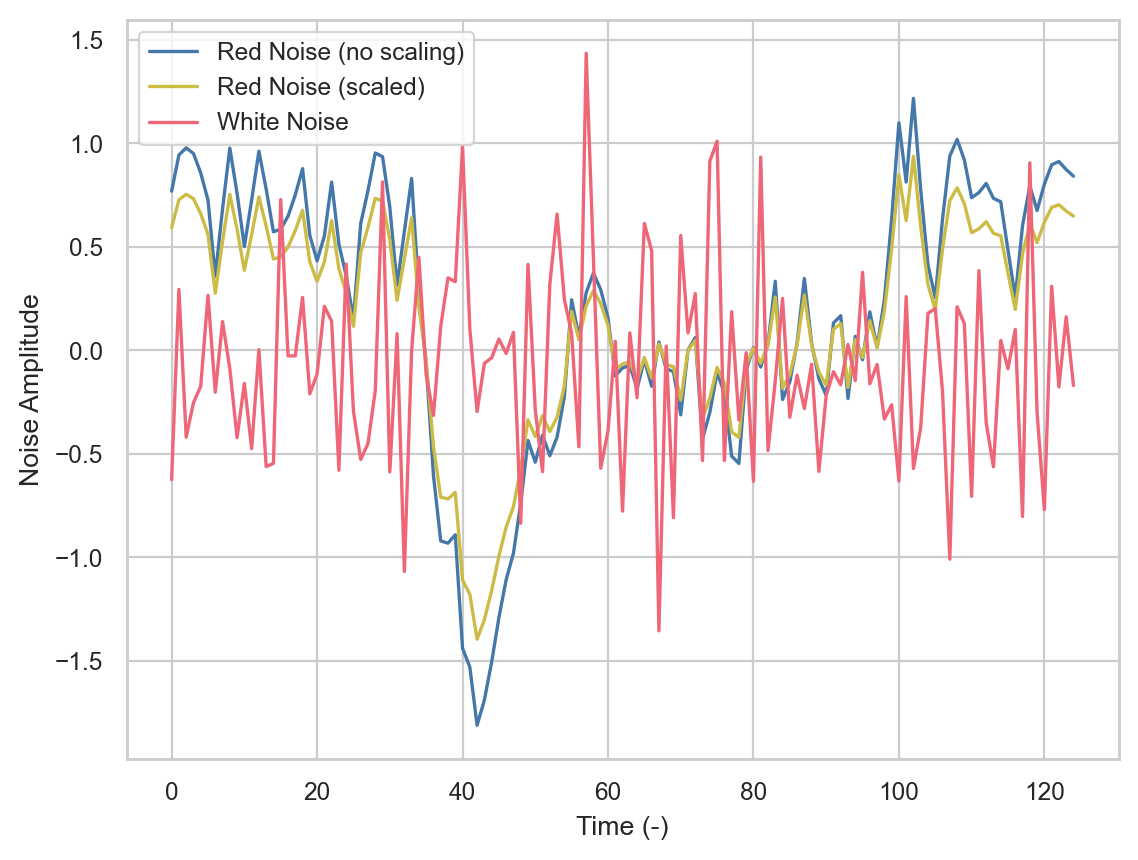

In [17]:
sigma = 0.5
beta = 2 # the exponent for red noise
samples = xclean.shape[1] # number of samples to generate
rng = np.random.default_rng(1)
y = cn.powerlaw_psd_gaussian(beta, samples, random_state=rng) 
plt.plot(y, label='Red Noise (no scaling)')
plt.plot(y * sigma / y.std(), label='Red Noise (scaled)')
plt.plot(sigma * rng.standard_normal(xclean.shape[1]), label='White Noise')
plt.gca().set_ylabel('Noise Amplitude')
plt.gca().set_xlabel('Time (-)')
plt.gca().legend()

Text(0.5, 1.0, 'Re(white noise)')

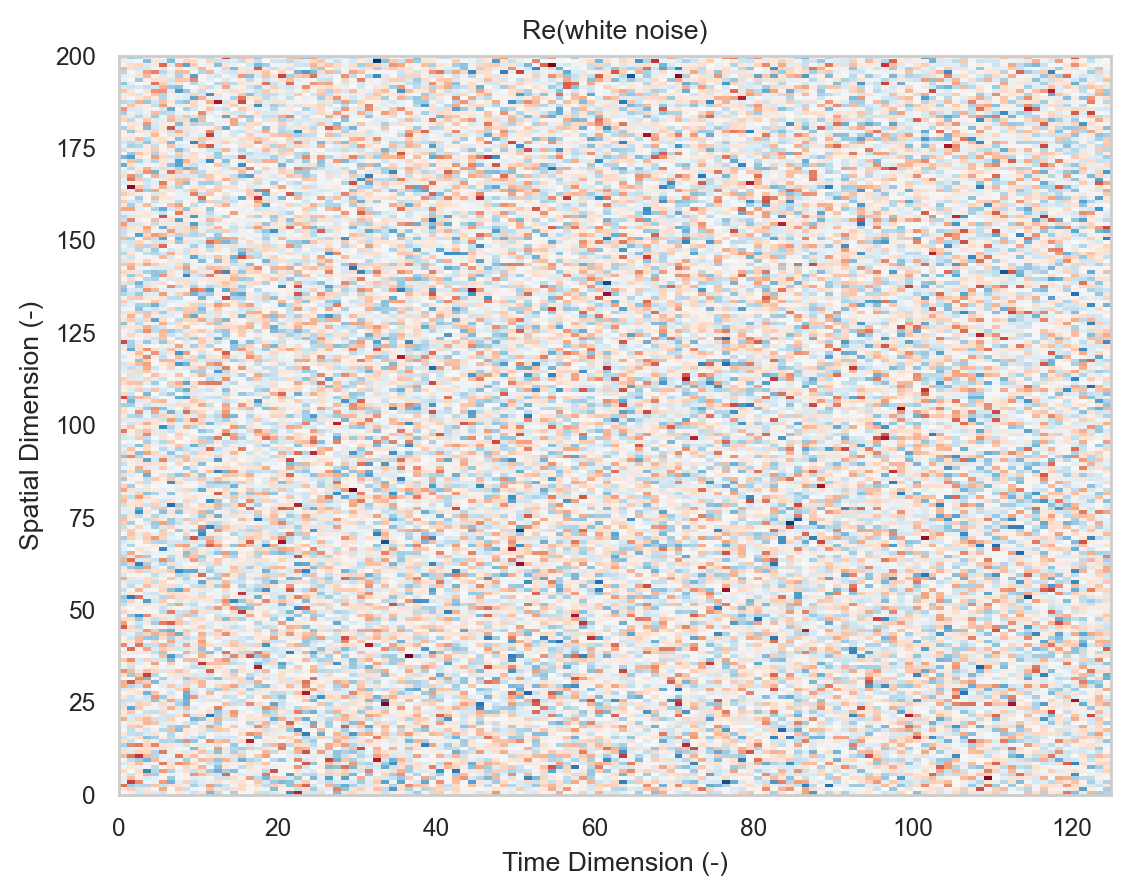

In [18]:
xdata_wn = (
    xclean
    + sigma * rng.standard_normal(xclean.shape)
    + 1j * sigma * rng.standard_normal(xclean.shape)
)

fig, ax = plt.subplots(1, 1)
plt.pcolormesh(np.real(xdata_wn - xclean), vmin=-2, vmax=2, cmap='RdBu_r')
ax.set_ylabel('Spatial Dimension (-)')
ax.set_xlabel('Time Dimension (-)')
ax.set_title('Re(white noise)')

Text(0.5, 1.0, 'Re(red noise)')

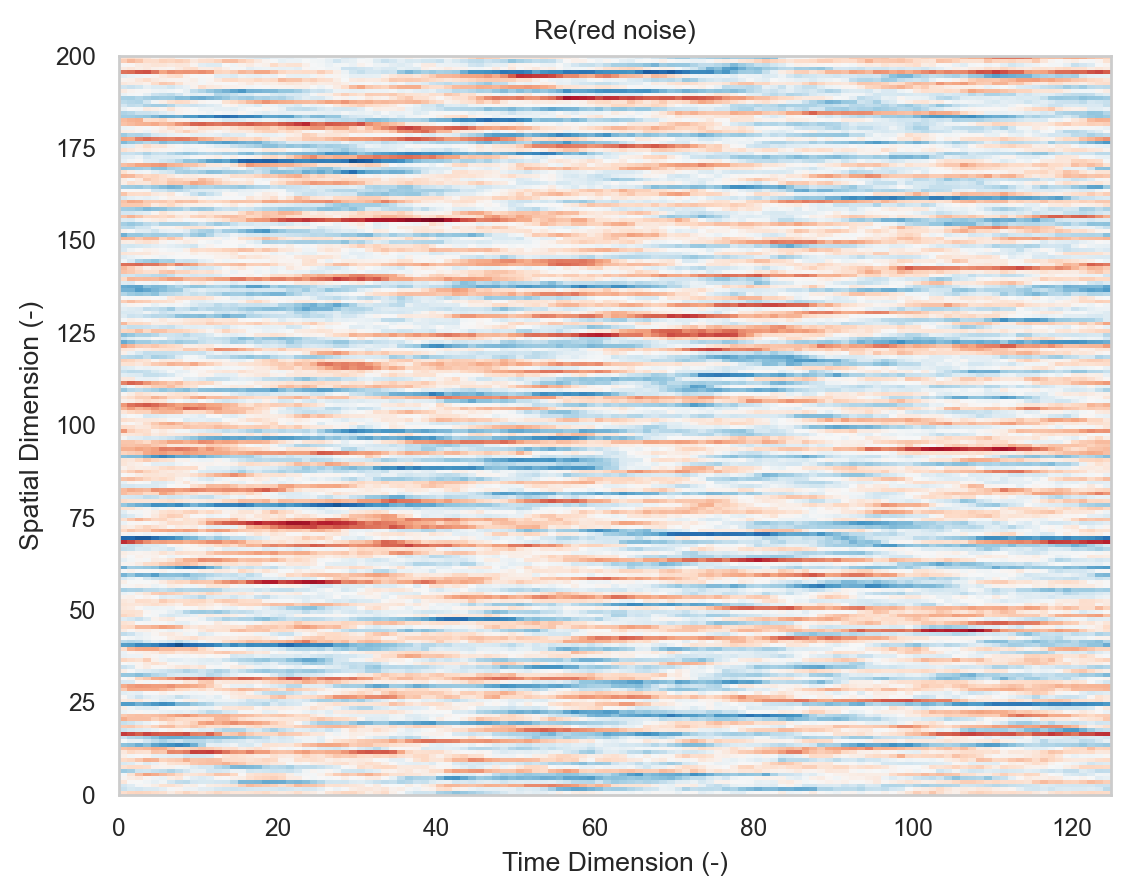

In [19]:
rng = np.random.default_rng(1)
rn_r = np.array([cn.powerlaw_psd_gaussian(beta, samples, random_state=rng) for _, _ in enumerate(xspace)])
rn_i = np.array([cn.powerlaw_psd_gaussian(beta, samples, random_state=rng) for _, _ in enumerate(xspace)])

rn_sigma_scaling = np.mean([sigma / rn_r.std(), sigma / rn_i.std()])
xdata_rn = (
    xclean
    + rn_sigma_scaling * rn_r
    + 1j * rn_sigma_scaling * rn_i
)

fig, ax = plt.subplots(1, 1)
plt.pcolormesh(np.real(xdata_rn - xclean), vmin=-2, vmax=2, cmap='RdBu_r')
ax.set_ylabel('Spatial Dimension (-)')
ax.set_xlabel('Time Dimension (-)')
ax.set_title('Re(red noise)')


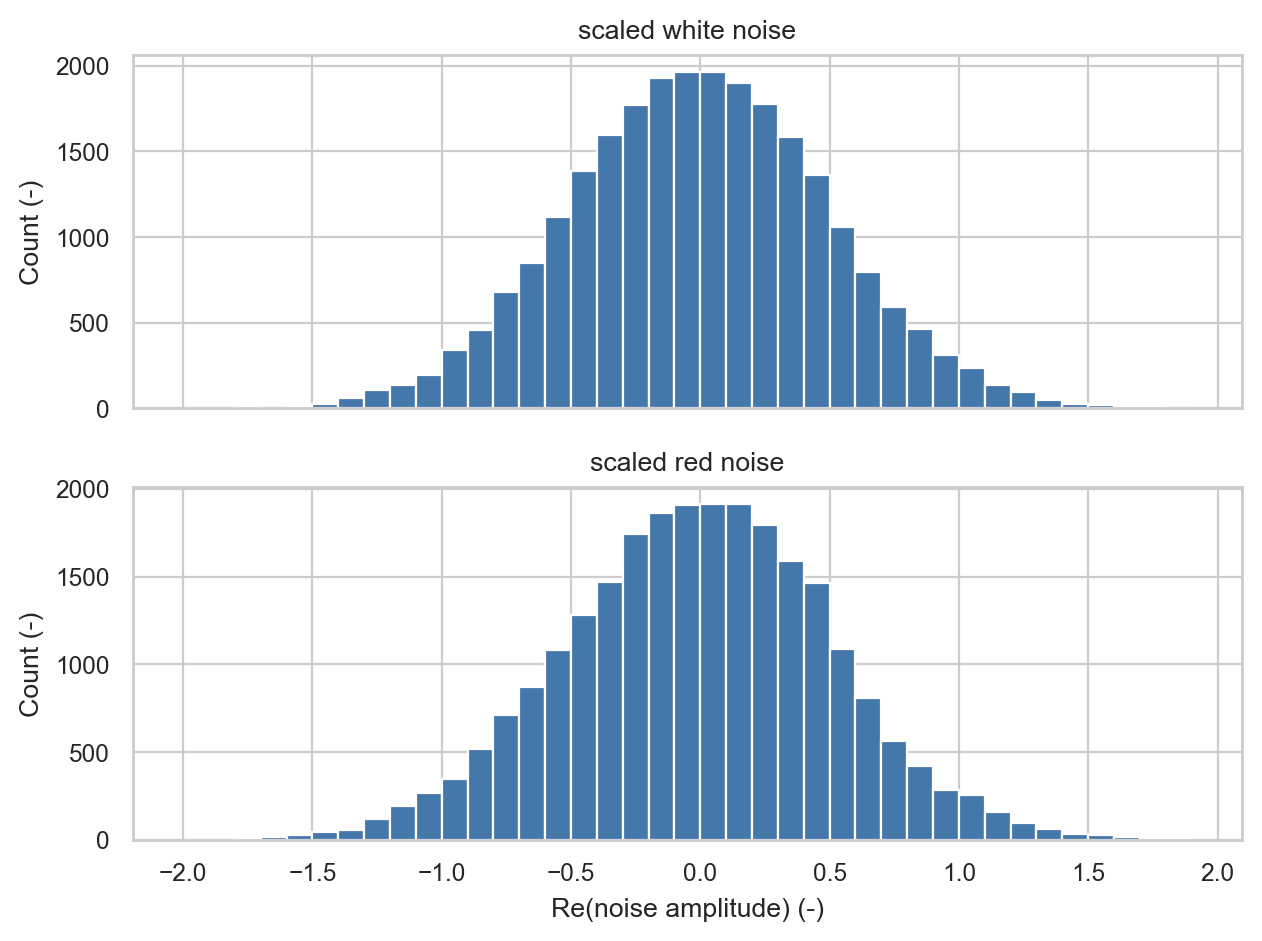

In [20]:
fig, axes = plt.subplots(2, 1, sharex=True)
ax = axes[0]
ax.hist(np.real(xdata_wn - xclean).flatten(), bins=np.arange(-2, 2, 0.1));
ax.set_title('scaled white noise')
ax.set_ylabel('Count (-)')

ax = axes[1]
ax.hist(np.real(rn_sigma_scaling * rn_r).flatten(), bins=np.arange(-2, 2, 0.1));
ax.set_title('scaled red noise')
ax.set_ylabel('Count (-)')
ax.set_xlabel('Re(noise amplitude) (-)')
fig.tight_layout()

Text(0.5, 1.0, 'Re(data + red noise)')

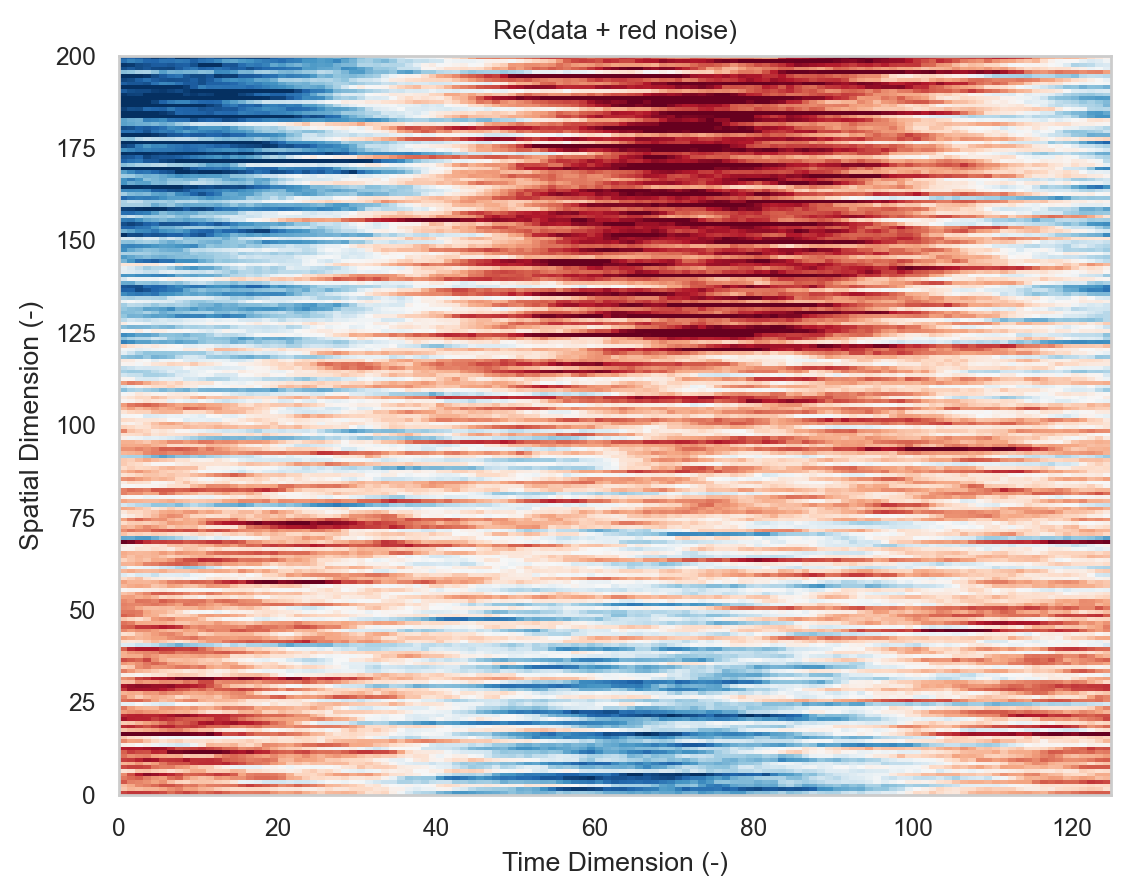

In [21]:
fig, ax = plt.subplots(1, 1)
ax.pcolormesh(np.real(xdata_rn), vmin=-2, vmax=2, cmap='RdBu_r')
ax.set_ylabel('Spatial Dimension (-)')
ax.set_xlabel('Time Dimension (-)')
ax.set_title('Re(data + red noise)')

## Common Parameters

In [22]:
# Number of time points
n = len(ts)

# Number of noisy realizations to generate.
num_noise_cycles = 10
# Number of ensemble members for each noise realization.
num_ensembles =  50
# Number of points to select for each ensemble.
p = 0.3
ensemble_size = int(num_ensembles * p)

# Select a much larger noise level than in the paper to better illustrate
# improved ensemble selection strategies.
# sigma_array = [1e-1, 1e-2, 1e-3]
sigma_array = [5e-1, 1e-1]

verbose = False

# Test various strategies for improving the BOP-DMD fit

## Fitting without any improvement strategies

### Red Noise: Fit and Evaluate

In [23]:
ds_optdmd_rn, ds_bopdmd_rn, optdmd_container_rn, bopdmd_container_rn = run_noisy_realizations(
    xclean, ts, sigma_array, num_noise_cycles, num_ensembles, ensemble_size,
    true_eigenvalues, seed=1, red_noise=True, ts_forecast=ts_forecast,
    data_forecast=xclean_forecast)


(0.0, 1.0)

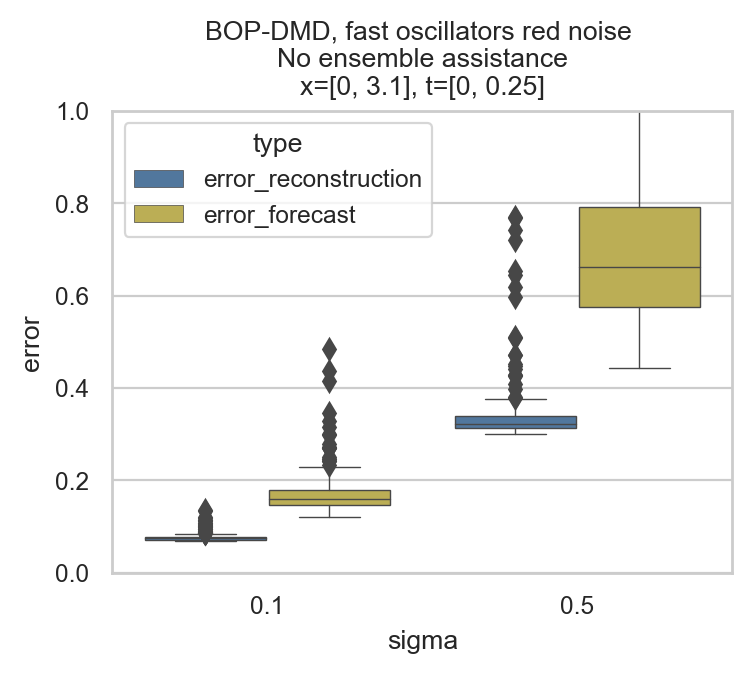

In [24]:
df = ds_bopdmd_rn[['error_reconstruction', 'error_forecast']].to_dataframe().reset_index()
df = pd.melt(df, value_vars=['error_reconstruction', 'error_forecast'], value_name='error', var_name='type', id_vars='sigma')
fig, ax = plt.subplots(1, 1, figsize=(4, 3,))
g = sns.boxplot(data=df, x='sigma', y='error', hue='type', linewidth=0.5, ax=ax)
g.set_title("BOP-DMD, fast oscillators red noise \nNo ensemble assistance\nx=[0, {:1.2}], t=[0, {:1.2f}]".format(x1, t1))
g.set_ylim(0, 1)

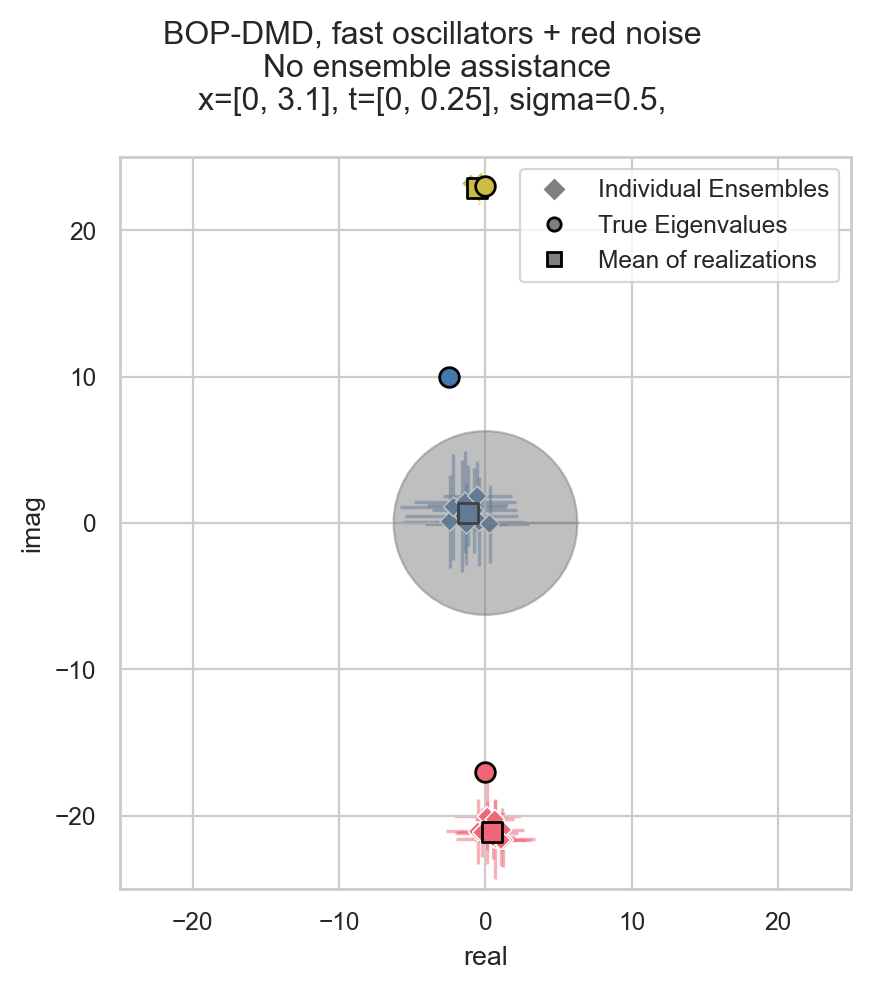

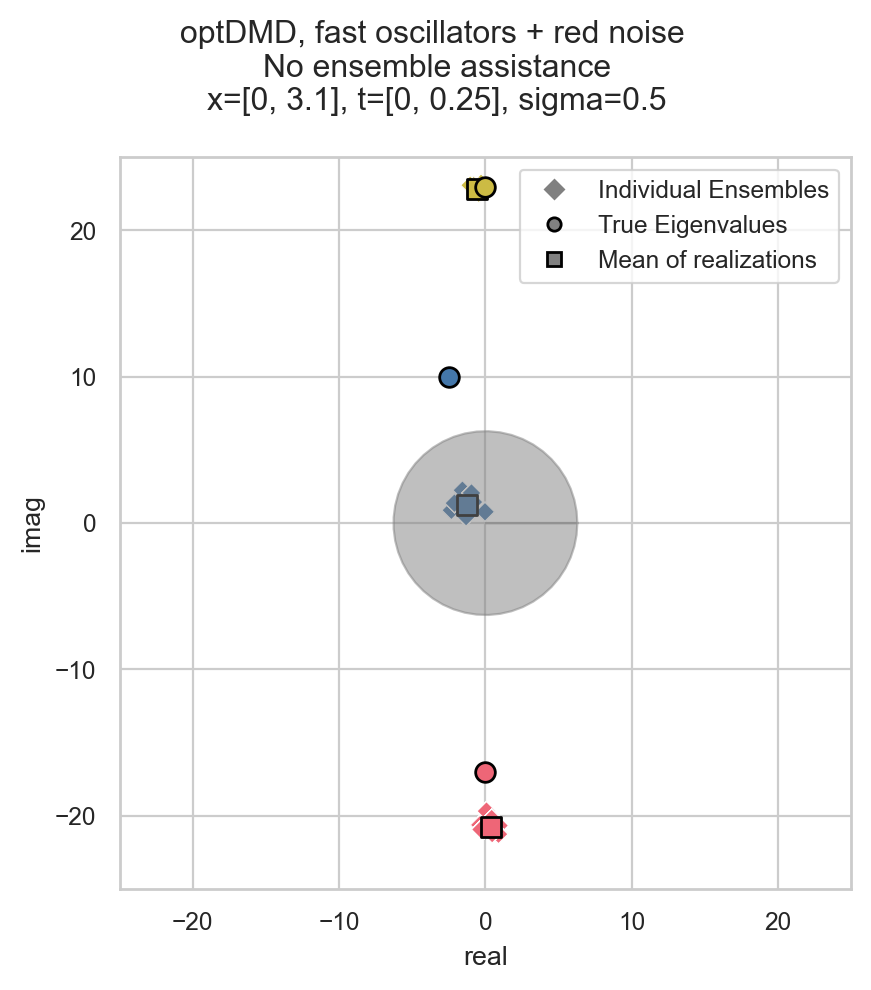

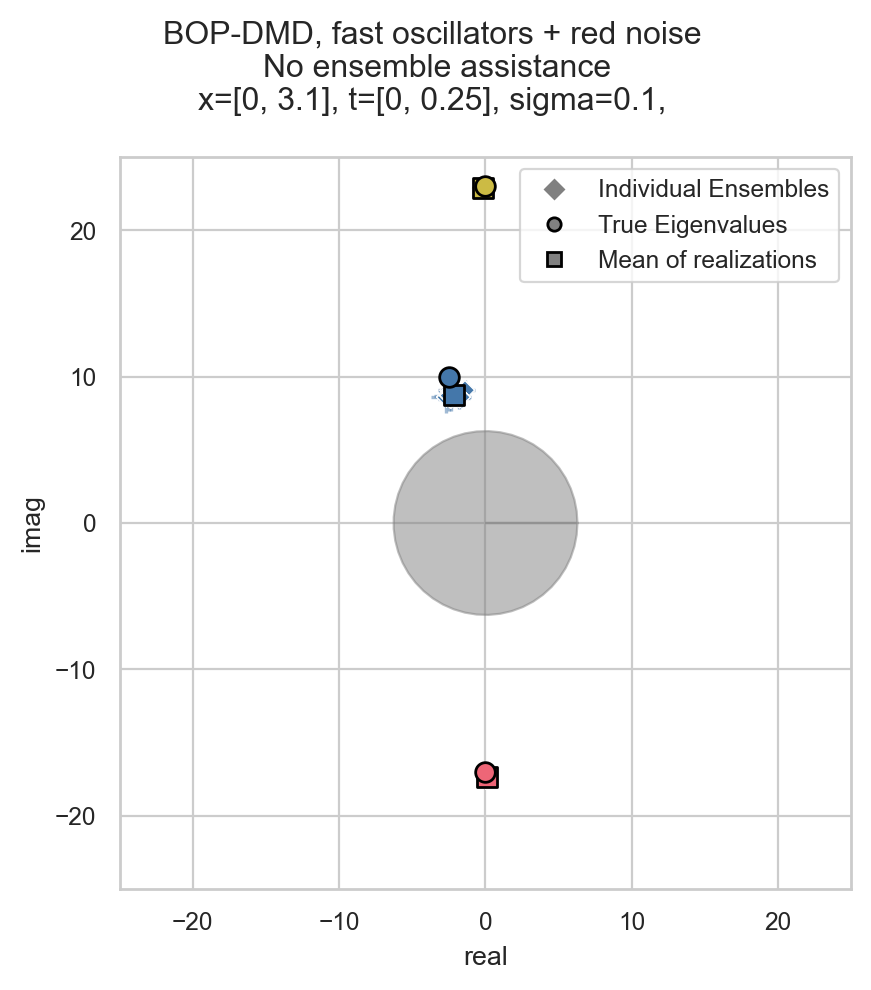

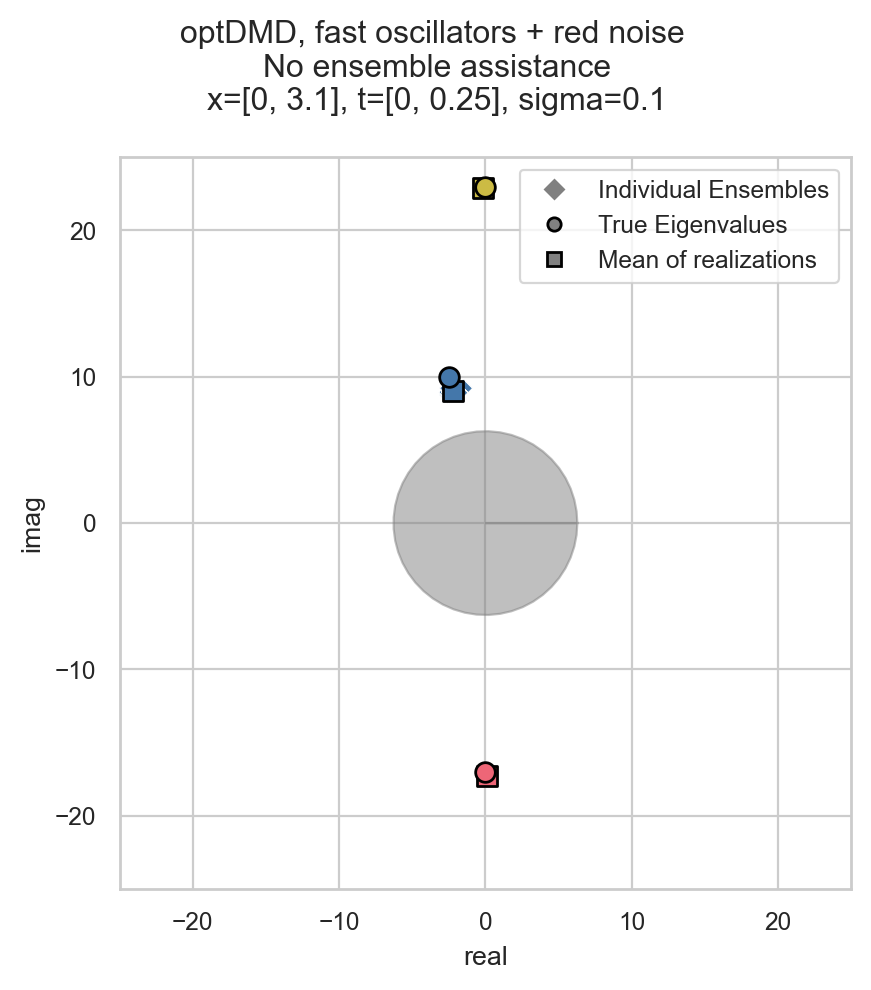

In [25]:
radii = [0, np.pi / (2 * t1)]
xs, ys = certainty_donut(radii)

# Distribution plots for the BOP-DMD and optDMD eigenvalues.
for s in sigma_array:
    plt.figure(figsize=(5, 5))
    g = eigenvalue_scatterplot(ds_bopdmd_rn.sel(sigma=s), true_eigenvalues, lims=(-25, 25))
    plt.gcf().suptitle(
        "BOP-DMD, fast oscillators + red noise \nNo ensemble assistance\nx=[0, {:1.2}], t=[0, {:1.2f}], sigma={}, ".format(x1, t1, s))
    plt.gcf().tight_layout()
    g.fill(xs, ys, edgecolor='k', color='0.5', alpha=0.5)

    plt.figure(figsize=(5, 5))
    g = eigenvalue_scatterplot(ds_optdmd_rn.sel(sigma=s), true_eigenvalues, lims=(-25, 25))
    plt.gcf().suptitle(
        "optDMD, fast oscillators + red noise \nNo ensemble assistance\nx=[0, {:1.2}], t=[0, {:1.2f}], sigma={}".format(x1, t1, s))
    plt.gcf().tight_layout()
    g.fill(xs, ys, edgecolor='k', color='0.5', alpha=0.5)


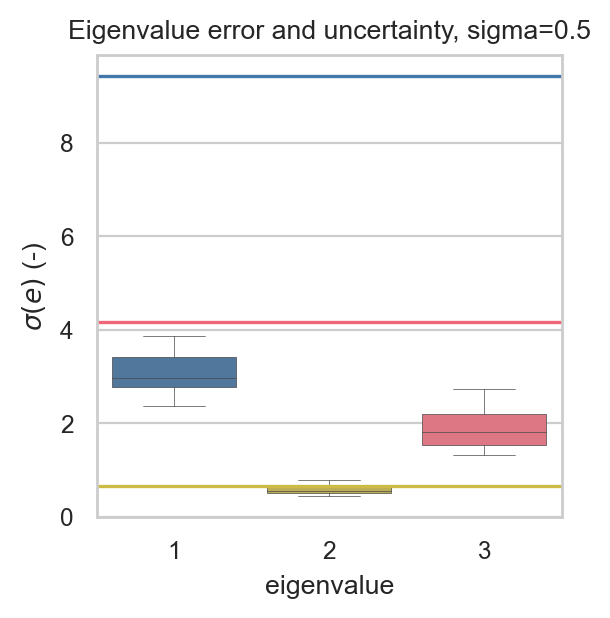

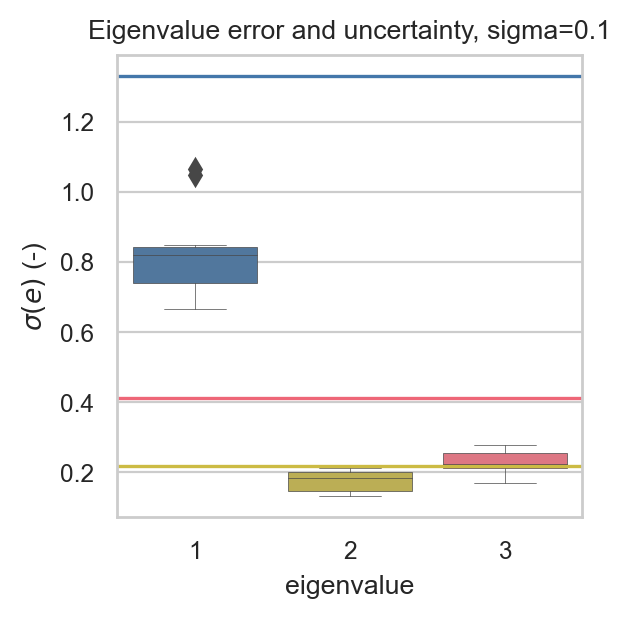

In [26]:
for s in sigma_array:
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ds = ds_bopdmd_rn.sel(sigma=s)
    df = ds.real_std.to_dataframe().reset_index()
    g = sns.boxplot(data=df, x='eigenvalue', y='real_std', ax=ax, linewidth=0.25)
    
    ax_xlims = ax.get_xlim()
    
    for ne, e in enumerate(ds.eigenvalue):
        ds_eign = ds.sel(eigenvalue=e).error_eigs
        ax.axhline(ds_eign.mean(dim='noise realization'), color=tol_bright_reorder[ne])

    ax.set_ylabel("$\sigma(e)$ (-)")
    ax.set_xlim(ax_xlims)
    ax.set_title('Eigenvalue error and uncertainty, sigma={}'.format(s))

### White Noise: Fit and Evaluate

In [27]:
ds_optdmd_wn, ds_bopdmd_wn, optdmd_container_wn, bopdmd_container_wn = run_noisy_realizations(
    xclean, ts, sigma_array, num_noise_cycles, num_ensembles, ensemble_size,
    true_eigenvalues, seed=1, red_noise=False, ts_forecast=ts_forecast,
    data_forecast=xclean_forecast)

(0.0, 1.0)

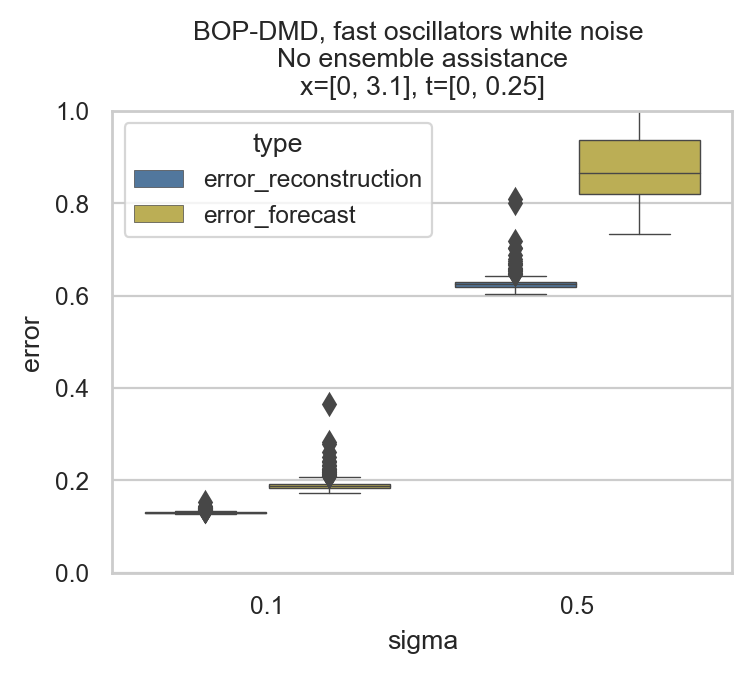

In [28]:
df = ds_bopdmd_wn[['error_reconstruction', 'error_forecast']].to_dataframe().reset_index()
df = pd.melt(df, value_vars=['error_reconstruction', 'error_forecast'], value_name='error', var_name='type', id_vars='sigma')

fig, ax = plt.subplots(1, 1, figsize=(4, 3,))
g = sns.boxplot(data=df, x='sigma', y='error', hue='type', linewidth=0.5, ax=ax)
g.set_title("BOP-DMD, fast oscillators white noise \nNo ensemble assistance\nx=[0, {:1.2}], t=[0, {:1.2f}]".format(x1, t1))
g.set_ylim(0, 1)

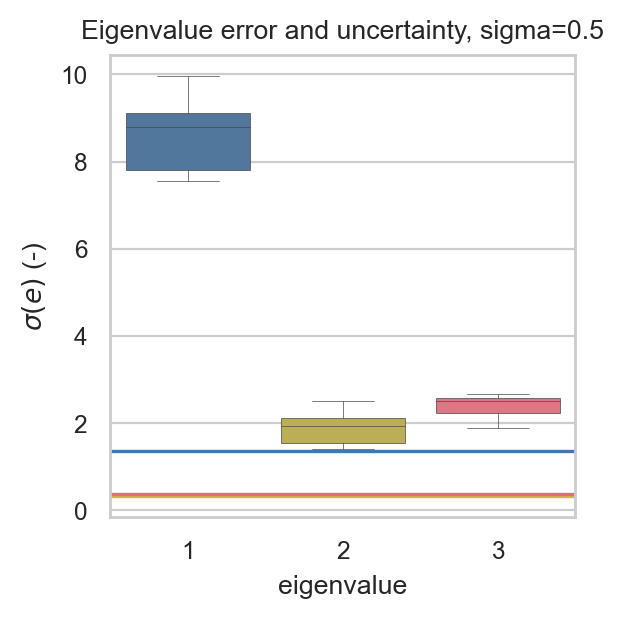

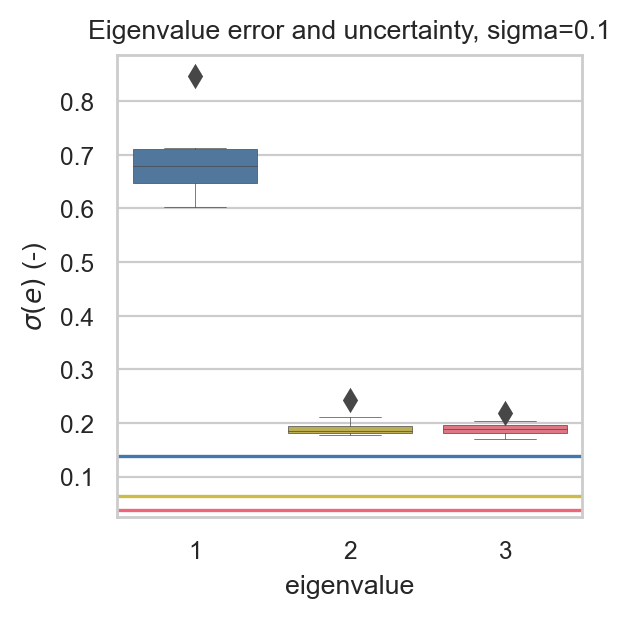

In [29]:
for s in sigma_array:
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ds = ds_bopdmd_wn.sel(sigma=s)
    df = ds.real_std.to_dataframe().reset_index()
    g = sns.boxplot(data=df, x='eigenvalue', y='real_std', ax=ax, linewidth=0.25)
    
    ax_xlims = ax.get_xlim()
    
    for ne, e in enumerate(ds.eigenvalue):
        ds_eign = ds.sel(eigenvalue=e).error_eigs
        ax.axhline(ds_eign.mean(dim='noise realization'), color=tol_bright_reorder[ne])

    ax.set_ylabel("$\sigma(e)$ (-)")
    ax.set_xlim(ax_xlims)
    ax.set_title('Eigenvalue error and uncertainty, sigma={}'.format(s))

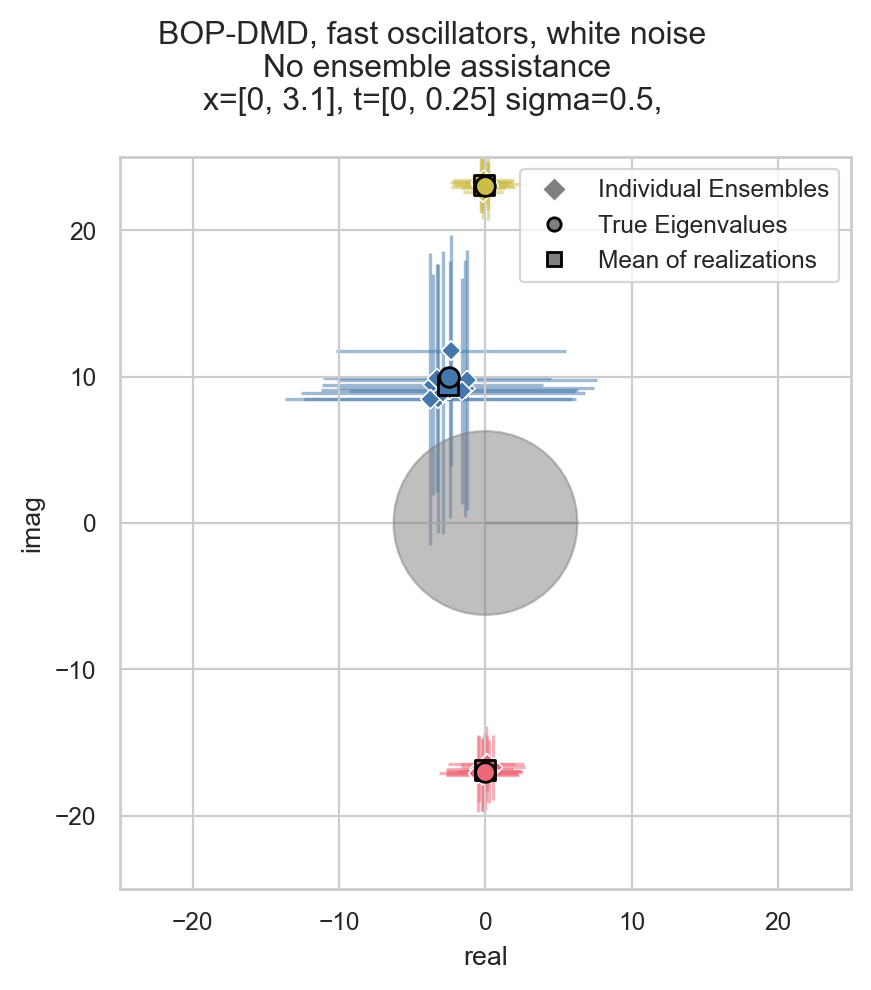

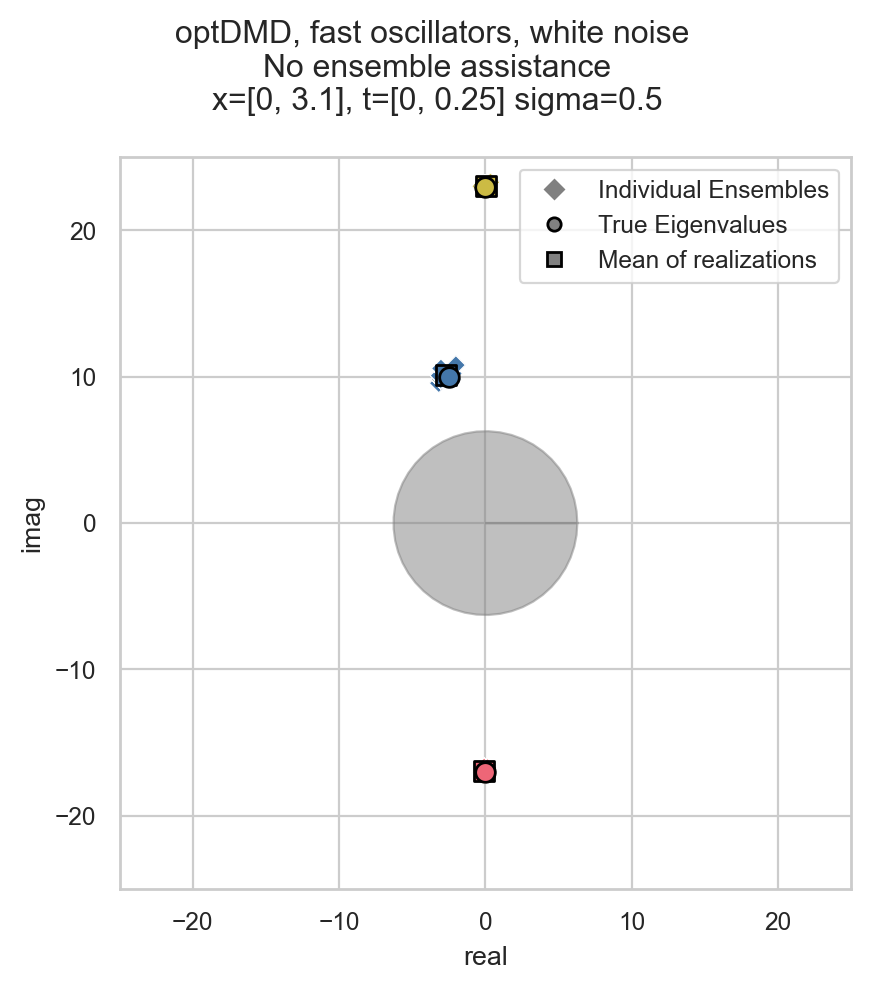

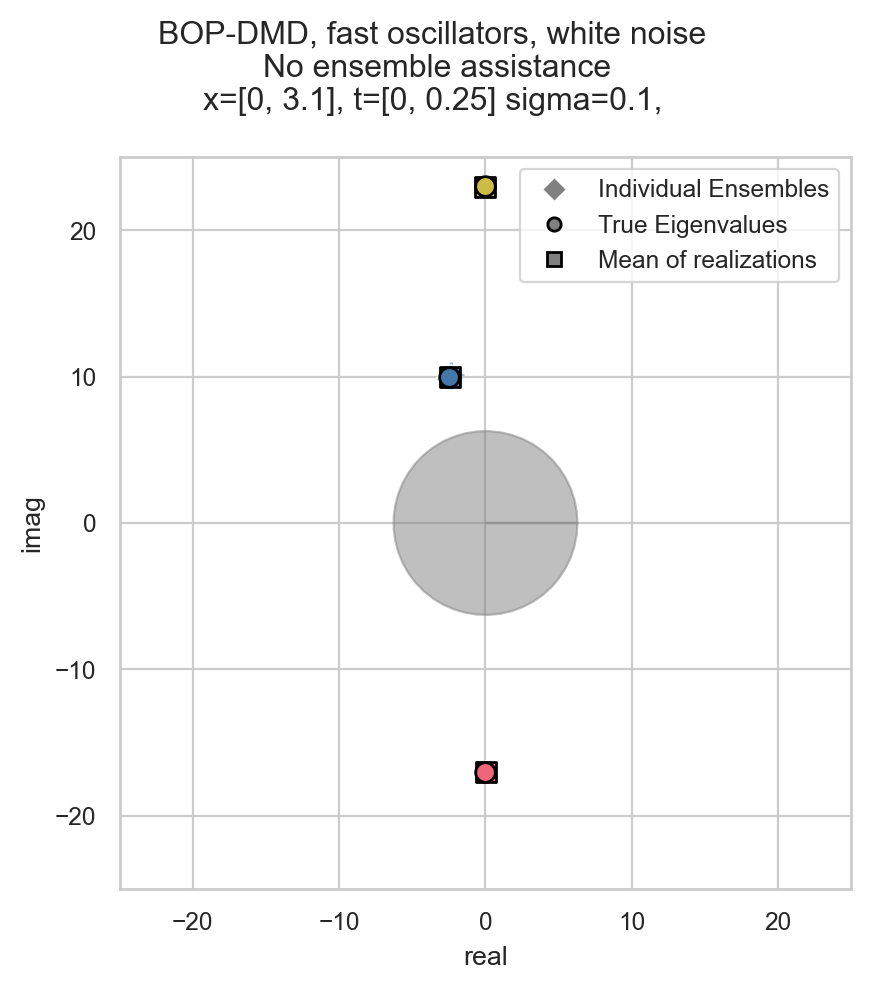

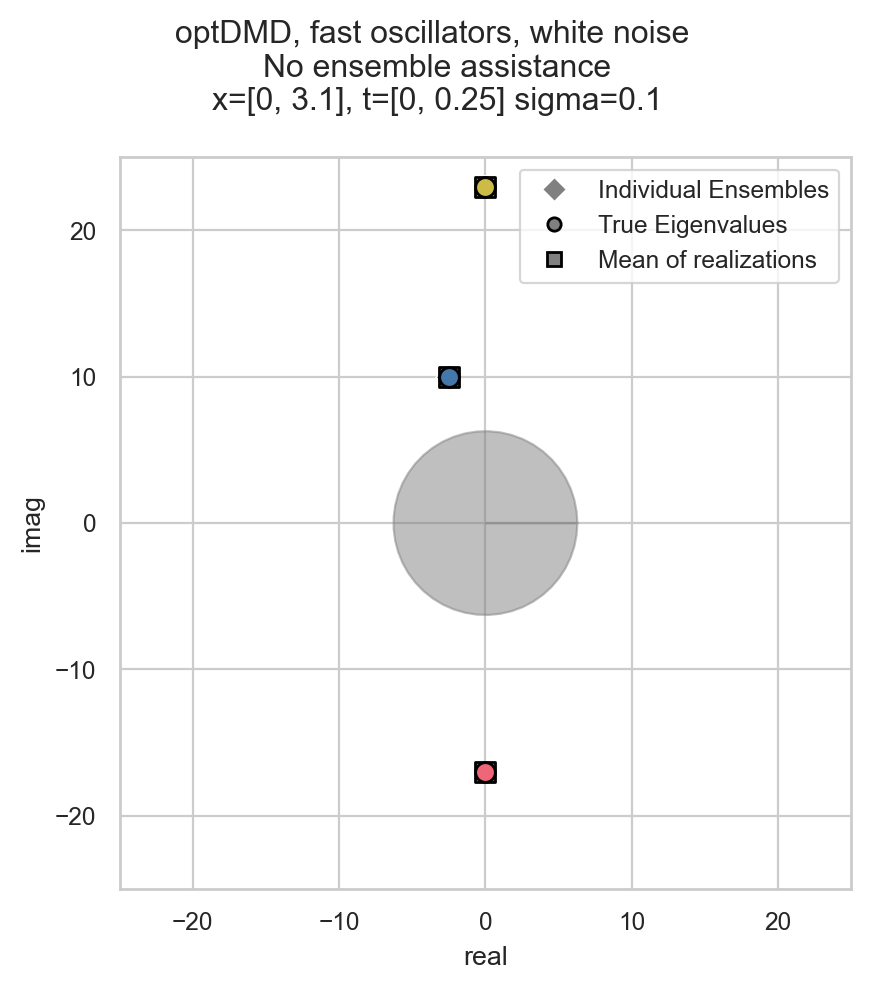

In [30]:
# Distribution plots for the BOP-DMD and optDMD eigenvalues.
for s in sigma_array:
    plt.figure(figsize=(5, 5))
    g = eigenvalue_scatterplot(ds_bopdmd_wn.sel(sigma=s), true_eigenvalues, lims=(-25, 25))
    plt.gcf().suptitle(
        "BOP-DMD, fast oscillators, white noise \nNo ensemble assistance\nx=[0, {:1.2}], t=[0, {:1.2f}] sigma={}, ".format(x1, t1, s))
    plt.gcf().tight_layout()
    g.fill(xs, ys, edgecolor='k', color='0.5', alpha=0.5)

    plt.figure(figsize=(5, 5))
    g = eigenvalue_scatterplot(ds_optdmd_wn.sel(sigma=s), true_eigenvalues, lims=(-25, 25))
    plt.gcf().suptitle(
        "optDMD, fast oscillators, white noise \nNo ensemble assistance\nx=[0, {:1.2}], t=[0, {:1.2f}] sigma={}".format(x1, t1, s))
    plt.gcf().tight_layout()
    g.fill(xs, ys, edgecolor='k', color='0.5', alpha=0.5)


## Including a long-term prior in the fit

### Establish weakly-informative priors

Next is to determine the long-term behavior for providing the priors. In a real application we would use expert knowledge (e.g., climatology for weather or oceanographic data).

**Not totally correct anymore but still captures the general idea**

To mimic this behavior in the toy system, we take block averages at a coarser time step than the original time domain used to fit the dmds (e.g., t_block = 30 * dt where dt=0.01, yielding blocks .3 in width).

For our "long term" data set this means 50 blocks (t2 = 15 with blocks of 0.3 width = 15 // 0.3 = 50).

The mean over the last dimension gives the mean of that time block.

**Notes**
- Using a `block_subdivision=1` (and offset of 4) leads to no improvment of the solutions +  a corruption of the eigenvalues towards negative values as the temporal dynamics decay away.

- Using a `block_subdivision=5` (and offset of 20) leads to substantial improvment since this is long enough to capture the relevant dynamics.



In [31]:
lt_length = 10
dt = int(nt)

# block_subdivision = 5
# num_block_time_offset = 20

block_subdivision = 1
num_block_time_offset = 4

block_size = dt // block_subdivision
offset = num_block_time_offset * block_size

# Give weakly informative priors for the long-term mean.
lt_mean = np.zeros((nx, lt_length))
# lt_climatology = np.atleast_2d(xclean_extended[:, slice(-lt_length * dt, None, dt)])

# Keep the space dimension, create a new dimension for the block, and make each block the appropriate width
lt_climatology = xclean_extended.reshape((xclean_extended.shape[0], -1, block_size)).mean(axis=-1)[:, block_subdivision + num_block_time_offset:]

# Set this long term mean to be far in the future.
# ts_lt = np.array([np.arange(t1 * 10, t1 * 10 + lt_length)])
# ts_lt = np.atleast_2d(ts_extended[:, slice(-lt_length * dt, None, dt)])
ts_lt = ts_extended[:, int(nt + dt // (block_subdivision * 2)) + offset::int(block_size)]

Using the climatology for the entire period creates too tight of a fit (no uncertainty in the eigenvalues)

Two strategies for making this more realistic and not overly constraining a toy system:

- Don't use the entire period of climatology, put it some time into the future
- Corrupt the climatology with some noise

Text(0.5, 1.0, 'Data with climatological priors')

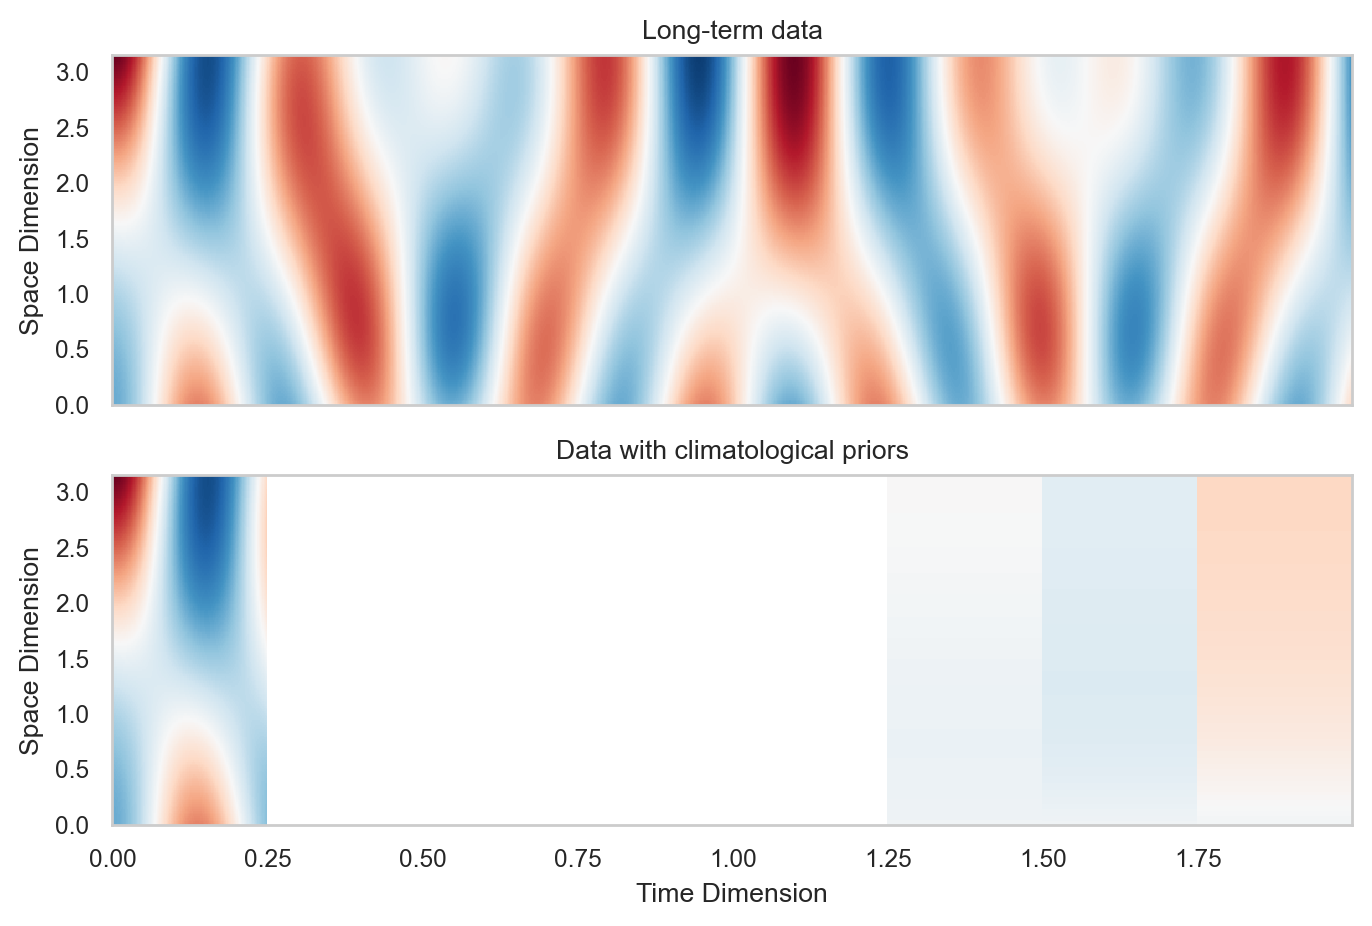

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

ax = axes[0]
c = ax.pcolormesh(ts_extended, xspace, np.real(xclean_extended), vmin=-2, vmax=2, cmap='RdBu')
# fig.colorbar(c)
ax.set_title('Long-term data')
ax.set_ylabel('Space Dimension')

ax = axes[1]
ax.pcolormesh(ts_lt, xspace, np.real(lt_climatology), vmin=-2, vmax=2, cmap='RdBu')
ax.pcolormesh(ts, xspace, np.real(xclean), vmin=-2, vmax=2, cmap='RdBu')
ax.set_xlabel('Time Dimension')
ax.set_ylabel('Space Dimension')
ax.set_title('Data with climatological priors')


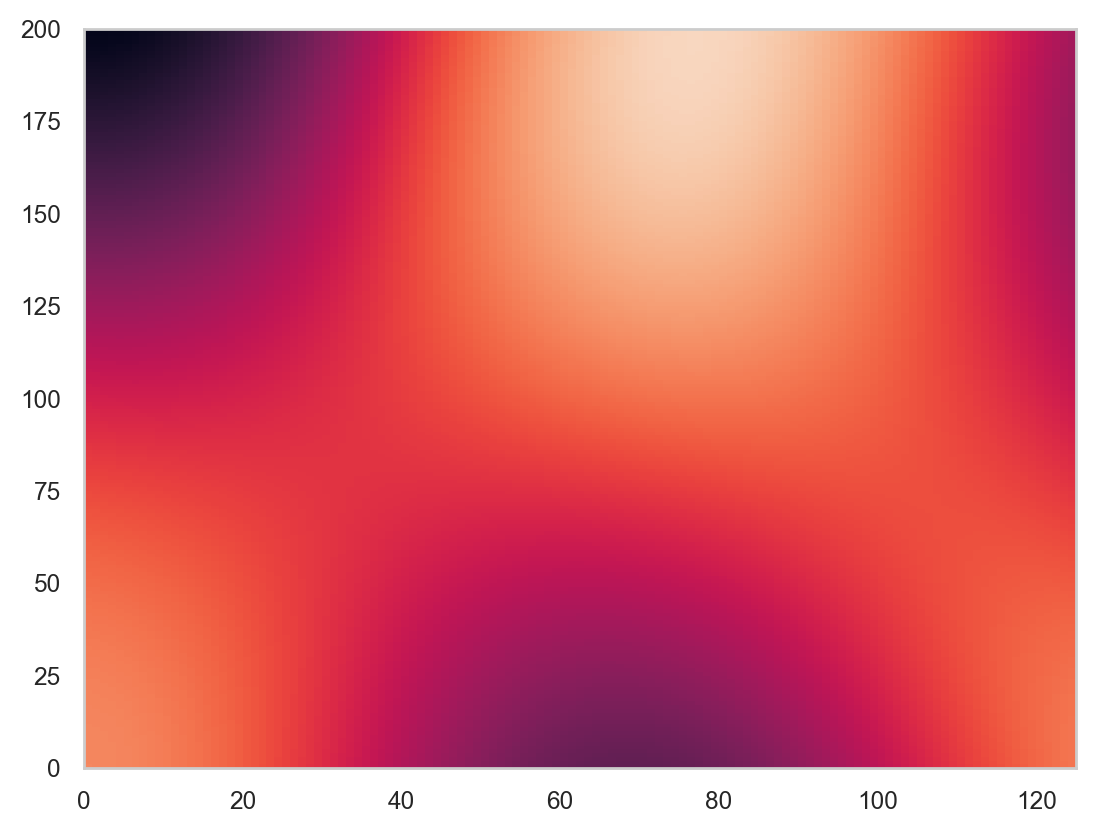

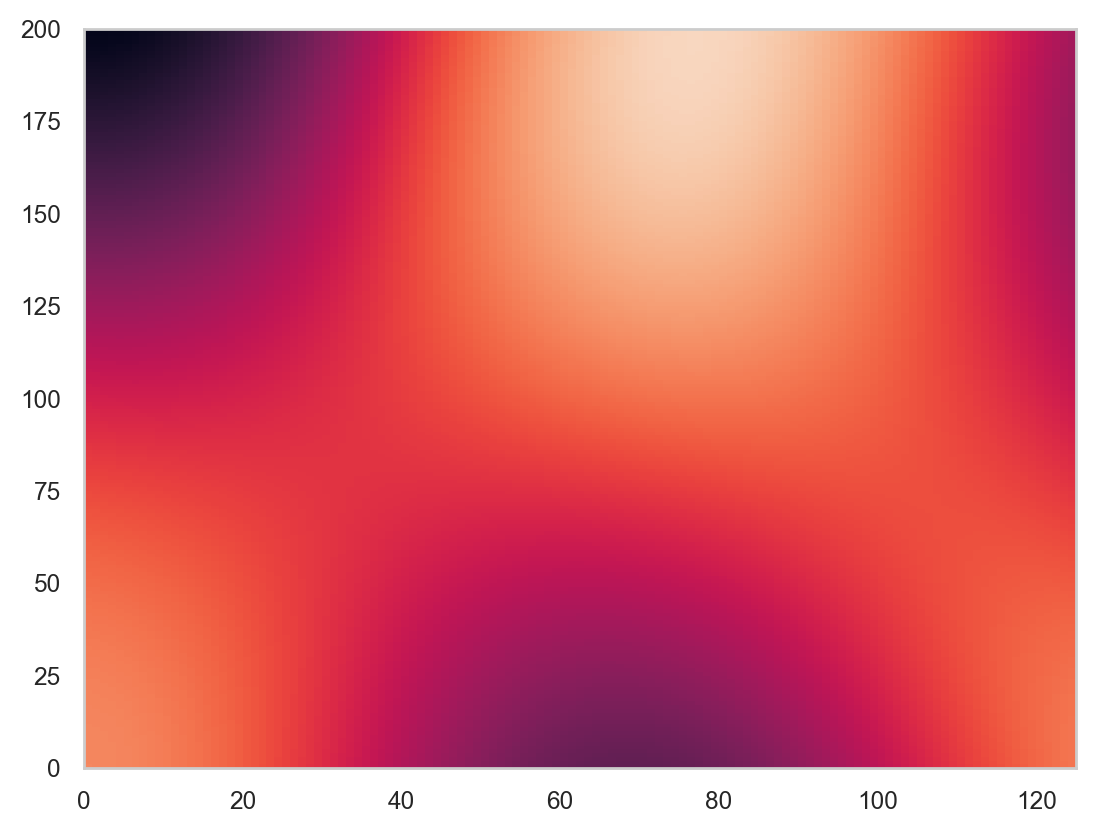

In [33]:
# This resahpe behavior can be quickly verified by settting the dt to the original dt and comparing to xclean
plt.pcolormesh(np.real(xclean), vmin=-2, vmax=2)

plt.figure()
plt.pcolormesh(np.real(xclean_extended.reshape((xclean_extended.shape[0], -1, dt))[:, 0, :]), vmin=-2, vmax=2)

And then we can compare the time mean for equivalent time blocks between xclean and the resahped long term data.

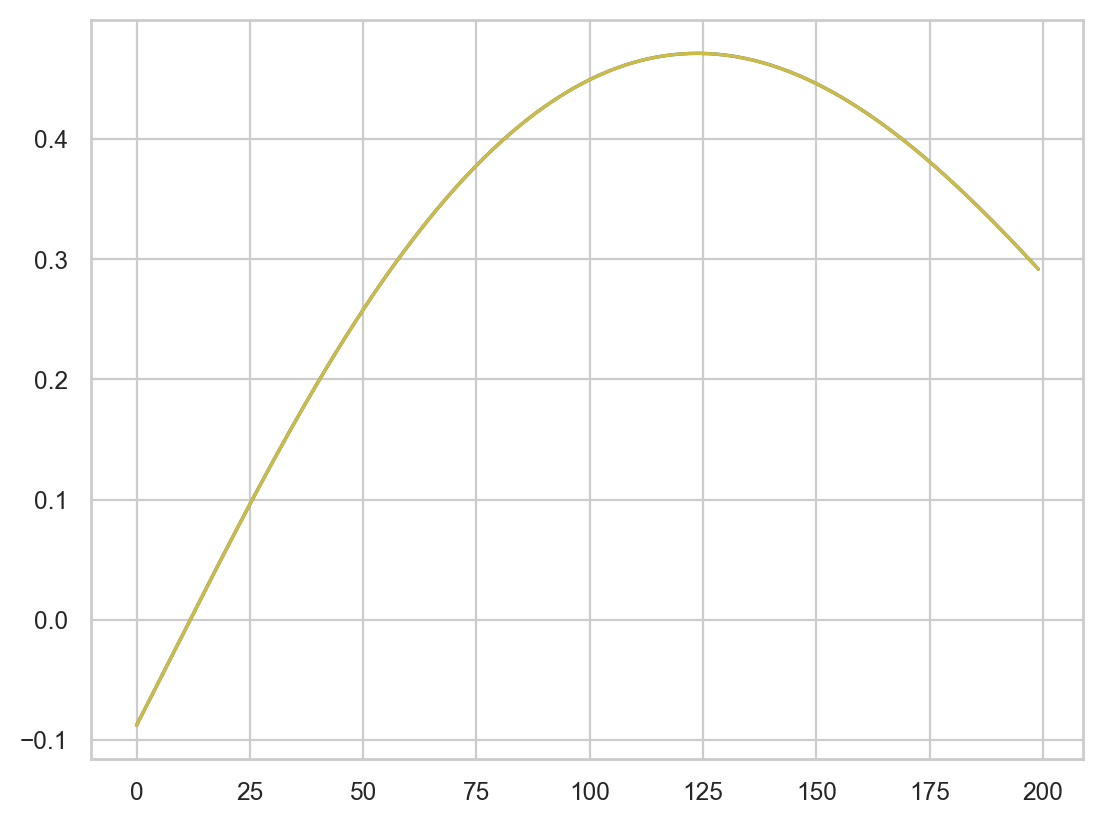

In [34]:
plt.plot(xclean_extended.reshape((xclean_extended.shape[0], -1, block_size)).mean(axis=-1)[:, 0])
plt.plot(xclean[:, 0:block_size].mean(axis=1))

### Fit + Climatology + White Noise

In [35]:
(ds_optdmd_wn_clim, ds_bopdmd_wn_clim, optdmd_container_wn_clim, bopdmd_container_wn_clim) = run_noisy_realizations(
    xclean, ts, sigma_array, num_noise_cycles, num_ensembles, ensemble_size,
    true_eigenvalues, seed=1, ts_longterm=ts_lt, data_longterm=lt_climatology,
    red_noise=False, ts_forecast=ts_forecast, data_forecast=xclean_forecast,
)


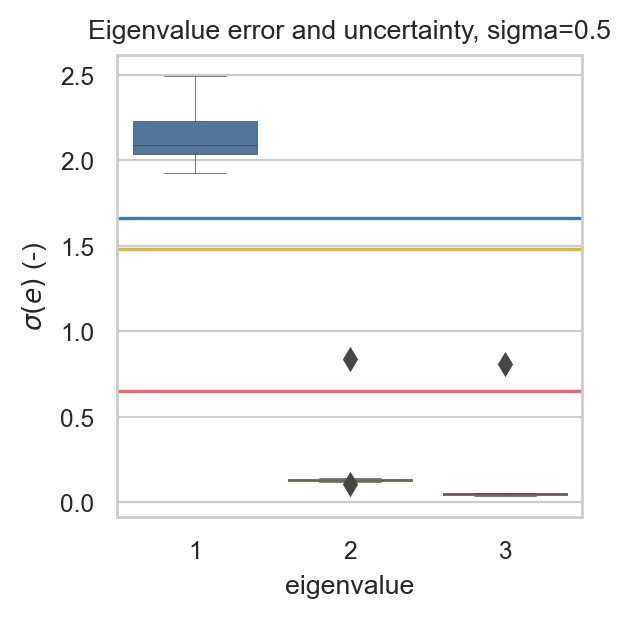

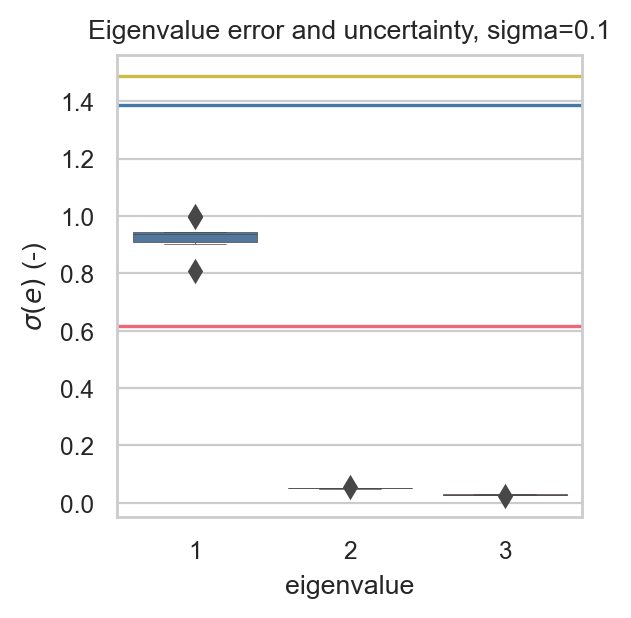

In [36]:
for s in sigma_array:
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ds = ds_bopdmd_wn_clim.sel(sigma=s)
    df = ds.real_std.to_dataframe().reset_index()
    g = sns.boxplot(data=df, x='eigenvalue', y='real_std', ax=ax, linewidth=0.25)
    
    ax_xlims = ax.get_xlim()
    
    for ne, e in enumerate(ds.eigenvalue):
        ds_eign = ds.sel(eigenvalue=e).error_eigs
        ax.axhline(ds_eign.mean(dim='noise realization'), color=tol_bright_reorder[ne])

    ax.set_ylabel("$\sigma(e)$ (-)")
    ax.set_xlim(ax_xlims)
    ax.set_title('Eigenvalue error and uncertainty, sigma={}'.format(s))

(0.0, 1.0)

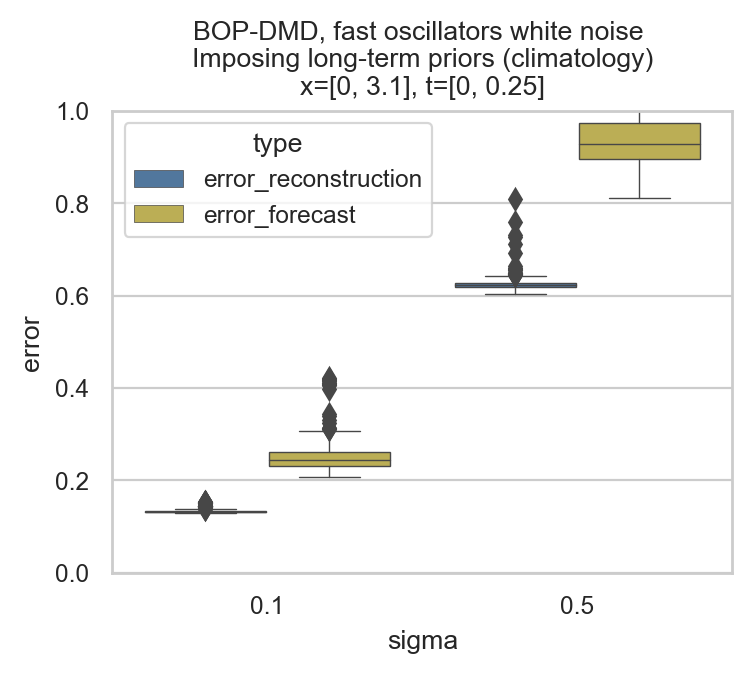

In [37]:
df = ds_bopdmd_wn_clim[['error_reconstruction', 'error_forecast']].to_dataframe().reset_index()
df = pd.melt(df, value_vars=['error_reconstruction', 'error_forecast'], value_name='error', var_name='type', id_vars='sigma')

fig, ax = plt.subplots(1, 1, figsize=(4, 3,))
g = sns.boxplot(data=df, x='sigma', y='error', hue='type', linewidth=0.5, ax=ax)
g.set_title("BOP-DMD, fast oscillators white noise \nImposing long-term priors (climatology)\nx=[0, {:1.2}], t=[0, {:1.2f}]".format(x1, t1))
g.set_ylim(0, 1)

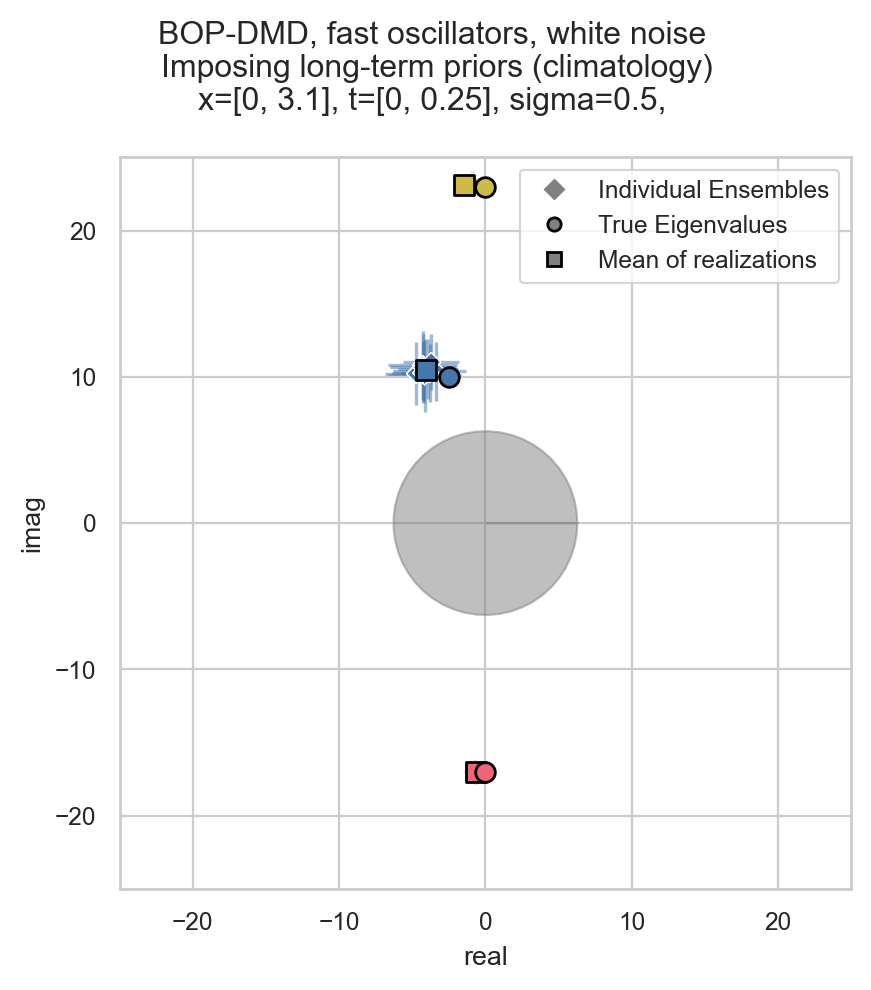

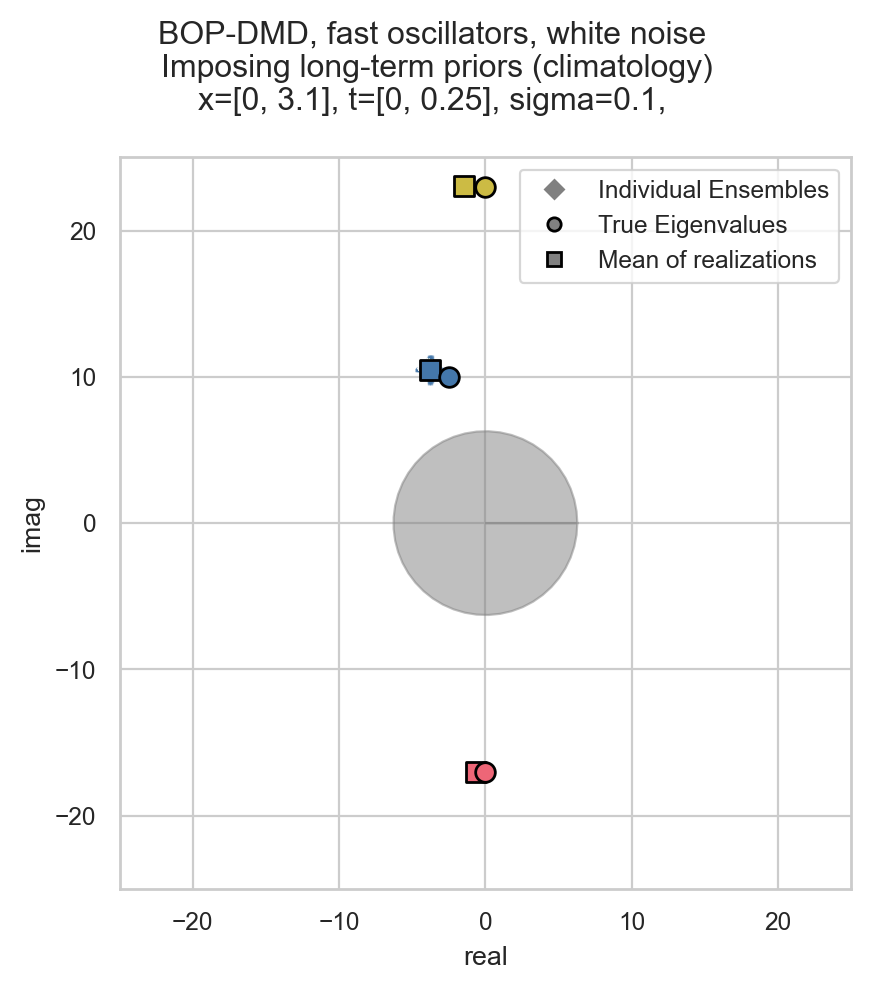

In [38]:
# Distribution plots for the BOP-DMD and optDMD eigenvalues.
for s in sigma_array:
    plt.figure(figsize=(5, 5))
    g = eigenvalue_scatterplot(ds_bopdmd_wn_clim.sel(sigma=s), true_eigenvalues, lims=(-25, 25))
    plt.gcf().suptitle(
        "BOP-DMD, fast oscillators, white noise \nImposing long-term priors (climatology)\nx=[0, {:1.2}], t=[0, {:1.2f}], sigma={}, ".format(x1, t1, s))
    plt.gcf().tight_layout()
    g.fill(xs, ys, edgecolor='k', color='0.5', alpha=0.5)


### Fit + Climatology + Red Noise

In [39]:
(ds_optdmd_rn_clim, ds_bopdmd_rn_clim, optdmd_rn_clim, bopdmd_rn_clim
) = run_noisy_realizations(
    xclean, ts, sigma_array, num_noise_cycles, num_ensembles, ensemble_size,
    true_eigenvalues, seed=1, ts_longterm=ts_lt, data_longterm=lt_climatology,
    red_noise=True, ts_forecast=ts_forecast, data_forecast=xclean_forecast,
)


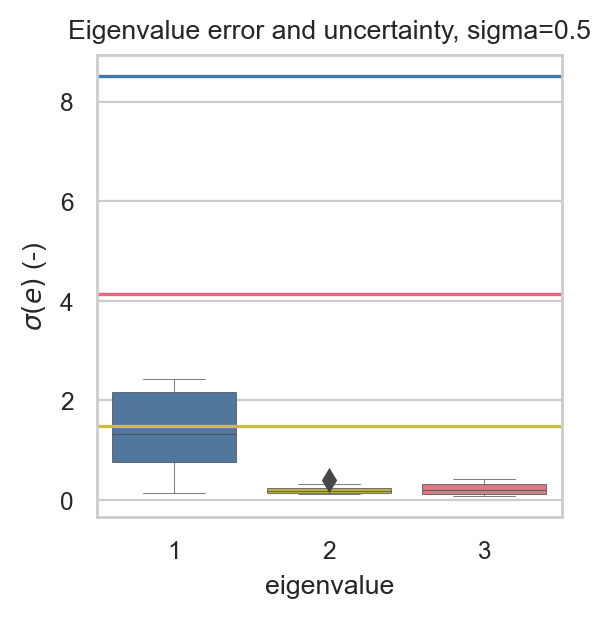

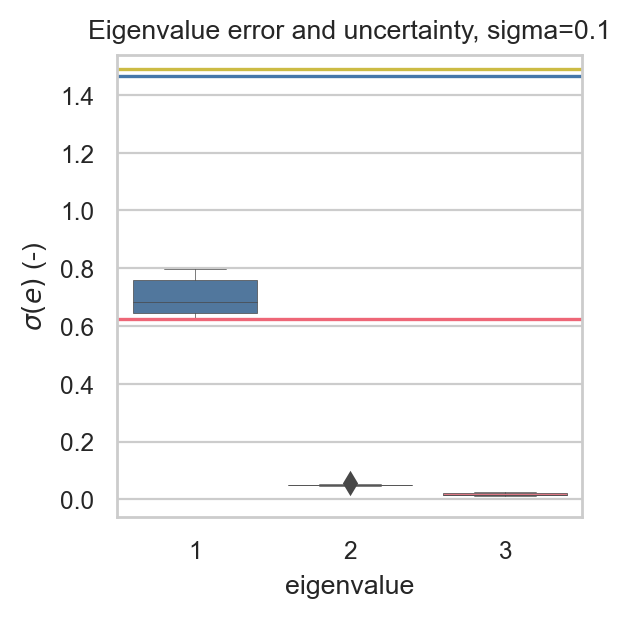

In [40]:
for s in sigma_array:
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ds = ds_bopdmd_rn_clim.sel(sigma=s)
    df = ds.real_std.to_dataframe().reset_index()
    g = sns.boxplot(data=df, x='eigenvalue', y='real_std', ax=ax, linewidth=0.25)
    
    ax_xlims = ax.get_xlim()
    
    for ne, e in enumerate(ds.eigenvalue):
        ds_eign = ds.sel(eigenvalue=e).error_eigs
        ax.axhline(ds_eign.mean(dim='noise realization'), color=tol_bright_reorder[ne])

    ax.set_ylabel("$\sigma(e)$ (-)")
    ax.set_xlim(ax_xlims)
    ax.set_title('Eigenvalue error and uncertainty, sigma={}'.format(s))

(0.0, 1.0)

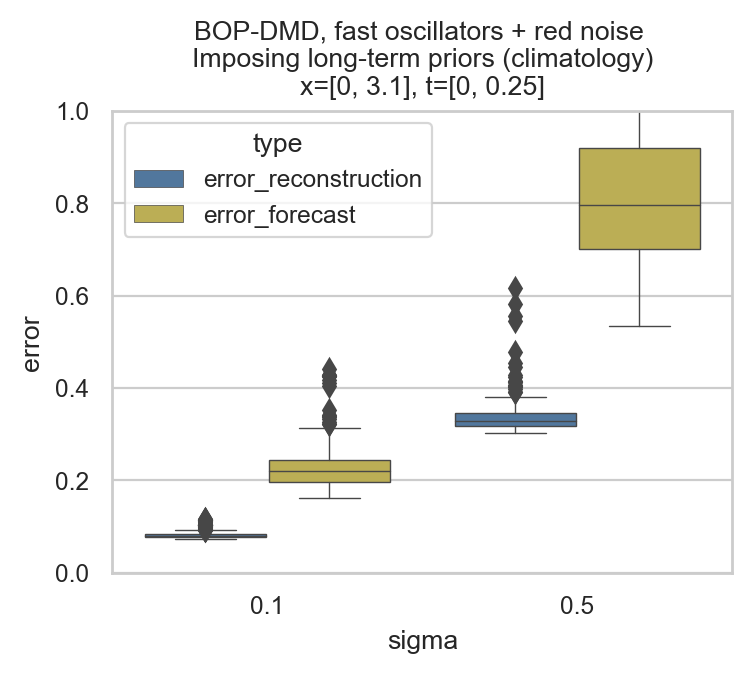

In [41]:
df = ds_bopdmd_rn_clim[['error_reconstruction', 'error_forecast']].to_dataframe().reset_index()
df = pd.melt(df, value_vars=['error_reconstruction', 'error_forecast'], value_name='error', var_name='type', id_vars='sigma')

fig, ax = plt.subplots(1, 1, figsize=(4, 3,))
g = sns.boxplot(data=df, x='sigma', y='error', hue='type', linewidth=0.5, ax=ax)
g.set_title("BOP-DMD, fast oscillators + red noise \nImposing long-term priors (climatology)\nx=[0, {:1.2}], t=[0, {:1.2f}]".format(x1, t1))
g.set_ylim(0, 1)

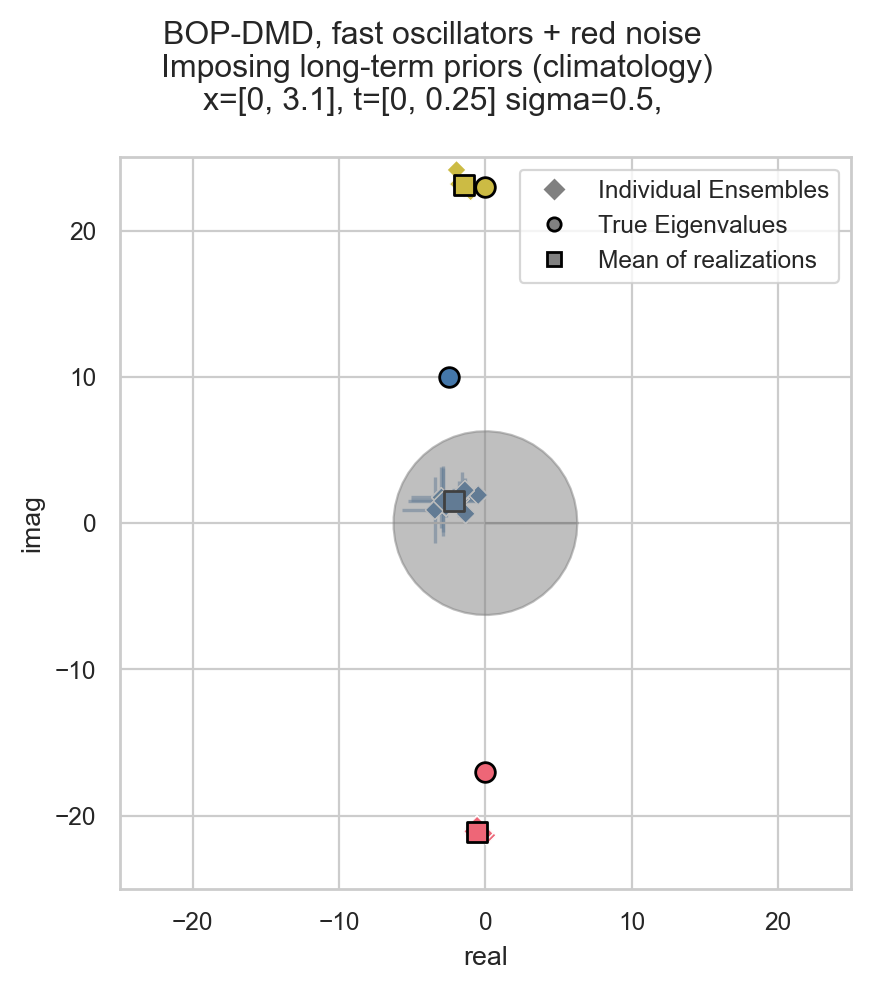

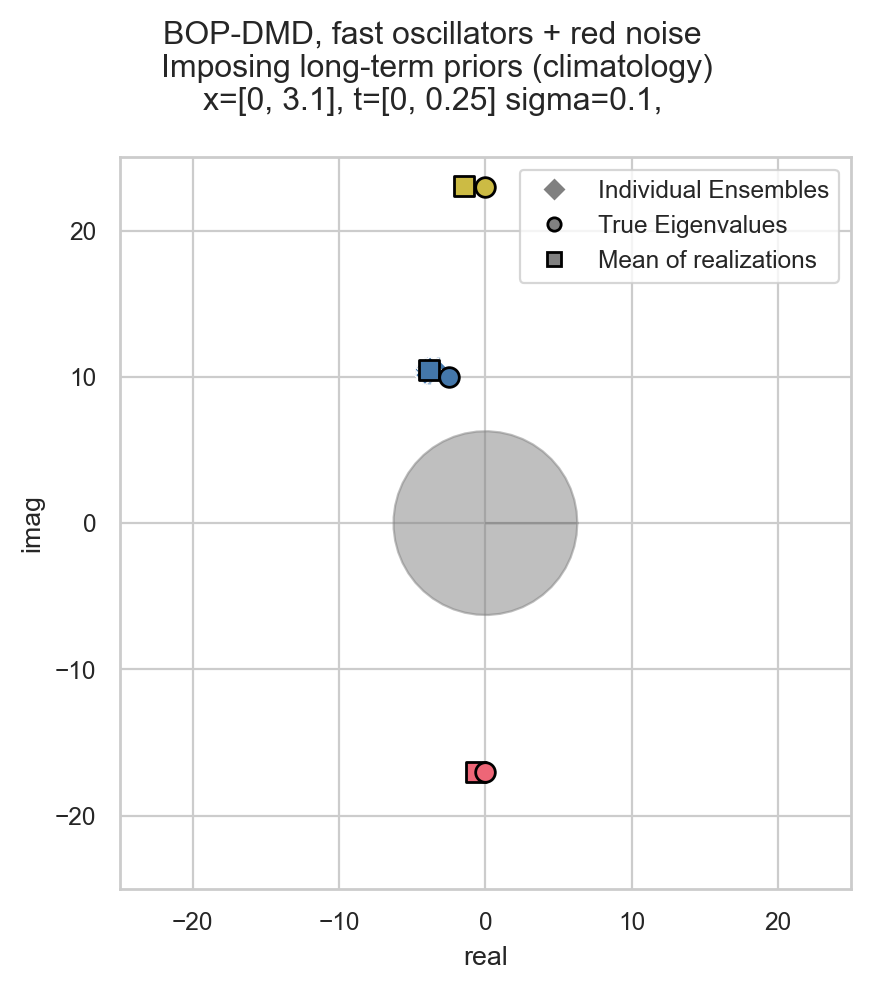

In [42]:
# Distribution plots for the BOP-DMD and optDMD eigenvalues.
for s in ds_bopdmd_rn_clim.sigma:
    plt.figure(figsize=(5, 5))
    g = eigenvalue_scatterplot(ds_bopdmd_rn_clim.sel(sigma=s), true_eigenvalues, lims=(-25, 25))
    plt.gcf().suptitle(
        "BOP-DMD, fast oscillators + red noise \nImposing long-term priors (climatology)\nx=[0, {:1.2}], t=[0, {:1.2f}] sigma={}, ".format(x1, t1, s.values))
    plt.gcf().tight_layout()
    g.fill(xs, ys, edgecolor='k', color='0.5', alpha=0.5)

How does eigenvalue uncertainty compare to the error from the true eigenvalue? As in is the uncertainty a true measure of uncertainty. Visually, for red noise, it clearly is not since the BOP-DMD derived uncertainty doesn't quite line-up with the perceived uncertainty, e.g., error between mean eigenvalues and the true eigenvalues.

## What happens in the long-term priors?

Just a simple demonstration of the impact of the long-term priors by looking at the solved temporal dynamics for individual ensemble members.

In [43]:
r = 0
s = sigma_array[0]
n = 0
b = bopdmd_rn_clim[s][r][n]
o = optdmd_rn_clim[s][r]

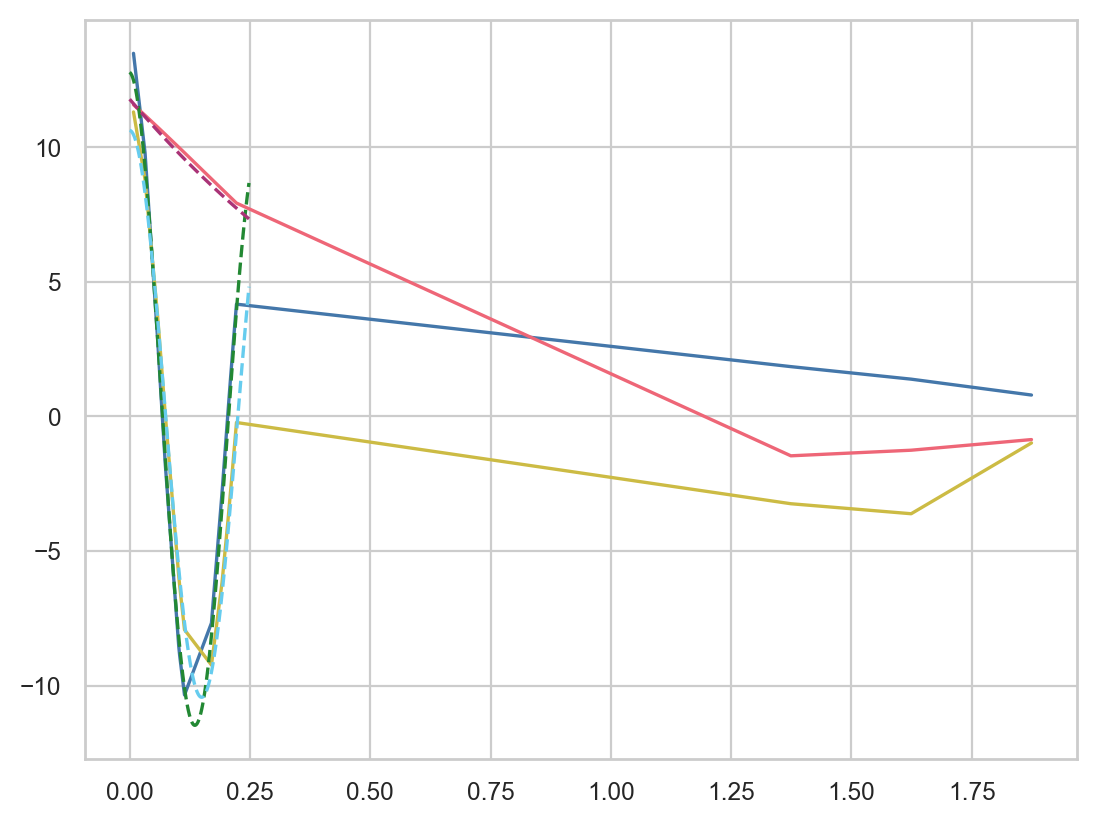

In [44]:
plt.plot(b.time, b.dynamics.T)
plt.plot(o.time, o.dynamics.T, ls='--')
# plt.gca().set_xlim(t0, t1)

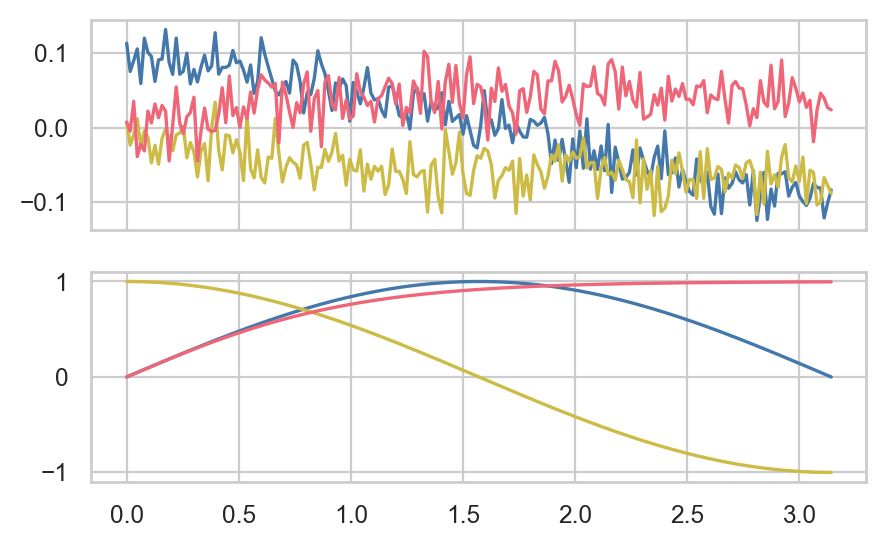

In [45]:
fig, axes = plt.subplots(2, 1, figsize=(5, 3), sharex=True)

ax = axes[0]
ax.plot(xspace, b.modes)

ax = axes[1]
ax.plot(xspace, f1)
ax.plot(xspace, f2)
ax.plot(xspace, f3)

# Trial size by noise level

The BOP-DMD paper makes some statements on the optimal trial size that are likely not true given the non-ideal nature of the toy data set (see Figure 4 of Sashidar and Kutz, 2022). I rerun those tests here to get around that issue.

0.5
0.1
0.01


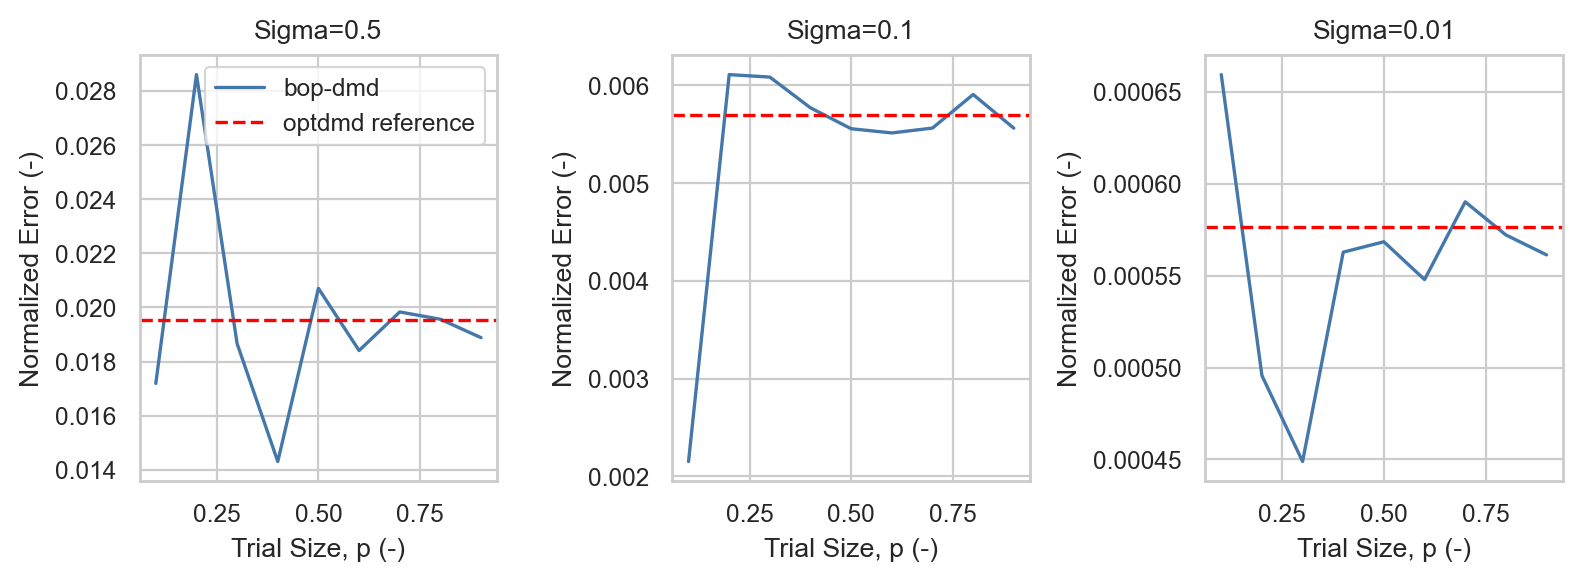

In [46]:
sigmas = [5e-1, 1e-1, 1e-2]
p_array = np.arange(10, 100, 10) / 100
number_ensembles = 100

fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True)

for ns, sigma in enumerate(sigmas):
    print(sigma)
    rng = np.random.default_rng(1)
    relerr_e = []
    xdata = (
        xclean
        + sigma * rng.standard_normal(xclean.shape)
        + 1j * sigma * rng.standard_normal(xclean.shape)
    )
    for p in p_array: 
        test_bopdmd = BOPDMD(
            svd_rank=3, trial_size=p, num_trials=number_ensembles)

        test_bopdmd.fit(xdata, ts)
        
        # Match the eigenvalues to the true ones using the Munkres algorithm.
        eigs = test_bopdmd.eigs
        _, indices = kl_bopdmd.match_vectors(eigs, true_eigenvalues)
        eigs = eigs[indices]
        
        relerr_e = np.append(relerr_e,
            np.linalg.norm(eigs - true_eigenvalues, 2)
            / np.linalg.norm(true_eigenvalues, 2)
        )
        
    ax = axes[ns]
    ax.plot(p_array, relerr_e, label='bop-dmd')
    
    # optdmd for comparison
    test_optdmd = BOPDMD(
        svd_rank=3, num_trials=0)
    test_optdmd.fit(xdata, ts)

    # Match the eigenvalues to the true ones using the Munkres algorithm.
    eigs = test_optdmd.eigs
    _, indices = kl_bopdmd.match_vectors(eigs, true_eigenvalues)
    eigs = eigs[indices]

    relerr_e = np.linalg.norm(eigs - true_eigenvalues, 2) / np.linalg.norm(true_eigenvalues, 2)
    ax.axhline(relerr_e, color='r', ls='--', label='optdmd reference')
    
    if ns == 0:
        ax.legend()
    ax.set_xlabel('Trial Size, p (-)')
    ax.set_ylabel('Normalized Error (-)')
    ax.set_title(
        'Sigma={}'.format(sigma)
    )
fig.tight_layout()

In [47]:
# sigmas = [5e-1, 1e-1, 1e-2]
sigma = 5e-1
p_array = [0.2, 0.3]
number_ensembles = 25

relerr_e_bop = {}
relerr_e_opt = {}

number_noisy_realizations = 25
relerr_e_opt[0] = np.ones((number_noisy_realizations))

for pcount, p in enumerate(p_array):
    print(p)
    relerr_e_bop[p] = np.ones((number_noisy_realizations))
    rng = np.random.default_rng(1)

    for ns in range(number_noisy_realizations):
        xdata = (
            xclean
            + sigma * rng.standard_normal(xclean.shape)
            + 1j * sigma * rng.standard_normal(xclean.shape)
        )
        test_bopdmd = BOPDMD(
            svd_rank=3, trial_size=p, num_trials=number_ensembles)
        test_bopdmd.fit(xdata, ts)
        
        # Match the eigenvalues to the true ones using the Munkres algorithm.
        eigs = test_bopdmd.eigs
        _, indices = kl_bopdmd.match_vectors(eigs, true_eigenvalues)
        eigs = eigs[indices]
        relerr_e_bop[p][ns] =  np.linalg.norm(eigs - true_eigenvalues, 2) / np.linalg.norm(true_eigenvalues, 2)
        
        if pcount == 0:

            # optdmd for comparison
            test_optdmd = BOPDMD(
                svd_rank=3, num_trials=0)
            test_optdmd.fit(xdata, ts)

            # Match the eigenvalues to the true ones using the Munkres algorithm.
            eigs = test_optdmd.eigs
            _, indices = kl_bopdmd.match_vectors(eigs, true_eigenvalues)
            eigs = eigs[indices]
            relerr_e_opt[0][ns] = np.linalg.norm(eigs - true_eigenvalues, 2) / np.linalg.norm(true_eigenvalues, 2)
        

0.2
0.3


In [48]:
df_relerr_e_opt = pd.DataFrame.from_dict(relerr_e_opt)
df_relerr_e_opt = pd.melt(df_relerr_e_opt, value_vars=[0], value_name='error', var_name='p')
df_relerr_e_bop = pd.DataFrame.from_dict(relerr_e_bop)
df_relerr_e_bop = pd.melt(df_relerr_e_bop, value_vars=[0.2, 0.3], value_name='error', var_name='p')
df = pd.concat([df_relerr_e_bop, df_relerr_e_opt], axis=0)
# df = df.loc[:,~df.columns.duplicated()]
# df = pd.melt(df, value_vars=['error'], value_name='eigenvalue error', id_vars='p')

(0.0, 0.4)

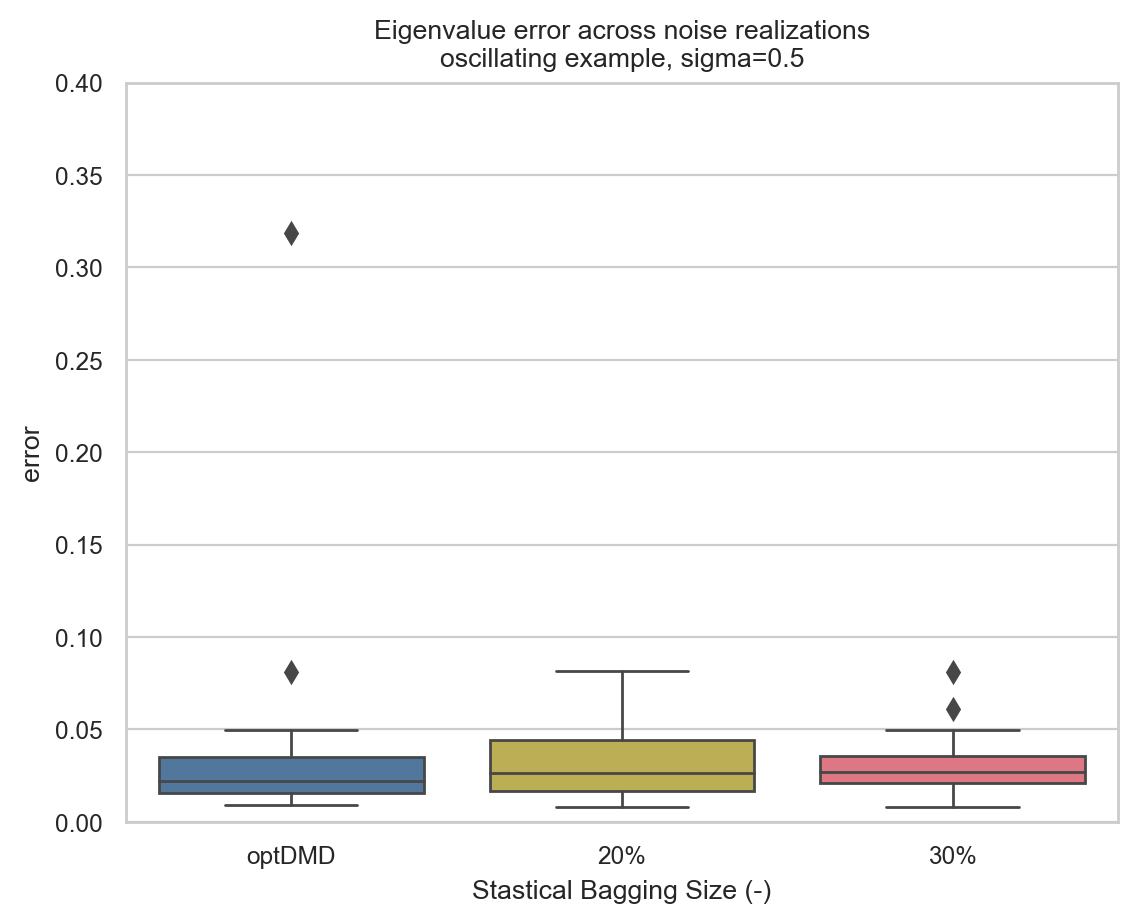

In [49]:
g = sns.boxplot(data=df, linewidth=1, x='p', y='error')
g.set_title('Eigenvalue error across noise realizations\noscillating example, sigma={}'.format(sigma))
g.set_xlabel('Stastical Bagging Size (-)')
g.set_xticklabels(['optDMD', '20%', '30%'])
g.set_ylim(0, 0.4)